In [1]:
# Calling the necessary libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import  XGBRegressor
from lightgbm import LGBMRegressor

## 1. Business Problem

It is desired to carry out a machine learning project regarding the prices of different types of houses, using the data set containing the features and house prices of each house.

## 2. Dataset Story

There are 79 explanatory variables in this dataset of homes in Ames, Iowa. Since the dataset is from a Kaggle contest, there are two different csv files: training and test. In the test dataset, house prices are left blank and these values are expected to be predicted.

## 3. Features

## 4. Tasks

In [2]:
# Load the dataset
df1 = pd.read_csv("datasets/train.csv")
df2 = pd.read_csv("datasets/test.csv")

df1.shape   # (1460, 81)
df2.shape 

(1459, 80)

In [3]:
# Read and combine the Train and Test data sets. Proceed through the data you combined.
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### 4.1 Exploratory Data Analysis(EDA)

In [4]:
def check_df(dataframe, head=5):
    print("######## Shape ########")
    print(dataframe.shape)
    print("######## Types ########")
    print(dataframe.dtypes)
    print("######## Head ########")
    print(dataframe.head())
    print("######## Tail ########")
    print((dataframe.tail()))
    print("######## NA ########")
    print(dataframe.isnull().sum())
    print("######## Quantiles ########")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

######## Shape ########
(2919, 81)
######## Types ########
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
######## Head ########
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [6]:
# Capture numerical and categorical variables.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

       It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be taken
        cat_th: int, optional
                Class threshold value for variables that are numeric but categorical
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        inside num_but_cat cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, car_th=26)

Observations: 2919
Variables: 81
cat_cols: 53
num_cols: 28
cat_but_car: 0
num_but_cat: 10


In [7]:
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'YrSold']

In [8]:
num_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SalePrice']

In [9]:
cat_but_car

[]

In [10]:
# Analyze numerical and categorical variables.

In [11]:
###################################
# ANALYSIS OF CATEGORICAL VARIABLES
###################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
          "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

          MSZoning      Ratio
MSZoning                     
RL            2265  77.595067
RM             460  15.758822
FV             139   4.761905
RH              26   0.890716
C (all)         25   0.856458
################


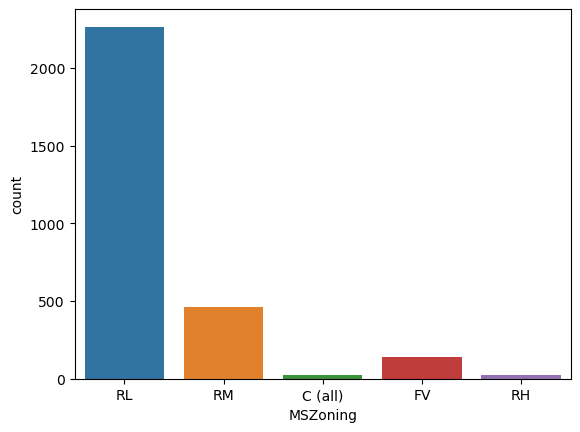

        Street    Ratio
Street                 
Pave      2907  99.5889
Grvl        12   0.4111
################


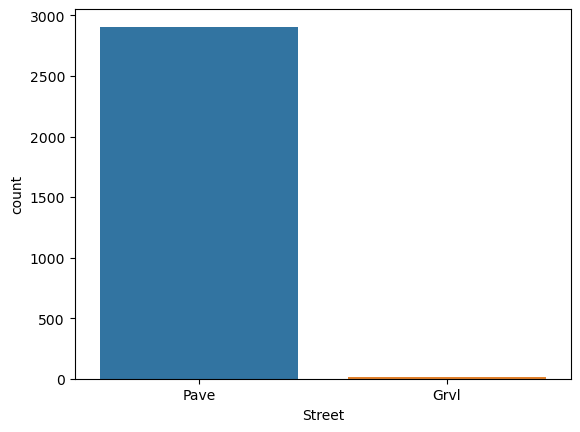

       Alley     Ratio
Alley                 
Grvl     120  4.110997
Pave      78  2.672148
################


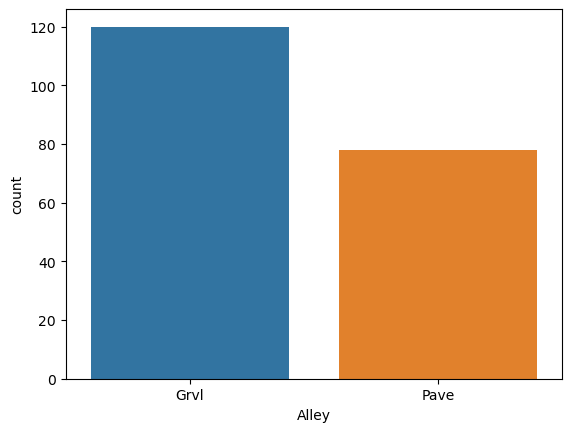

          LotShape      Ratio
LotShape                     
Reg           1859  63.686194
IR1            968  33.162042
IR2             76   2.603631
IR3             16   0.548133
################


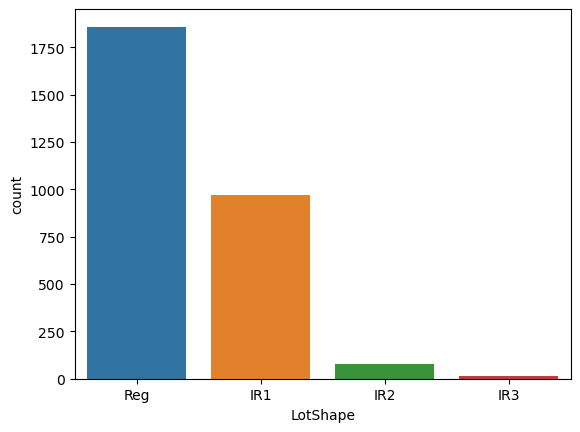

             LandContour      Ratio
LandContour                        
Lvl                 2622  89.825283
HLS                  120   4.110997
Bnk                  117   4.008222
Low                   60   2.055498
################


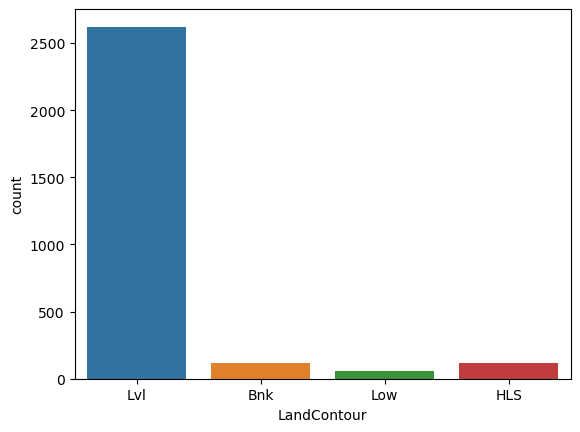

           Utilities      Ratio
Utilities                      
AllPub          2916  99.897225
NoSeWa             1   0.034258
################


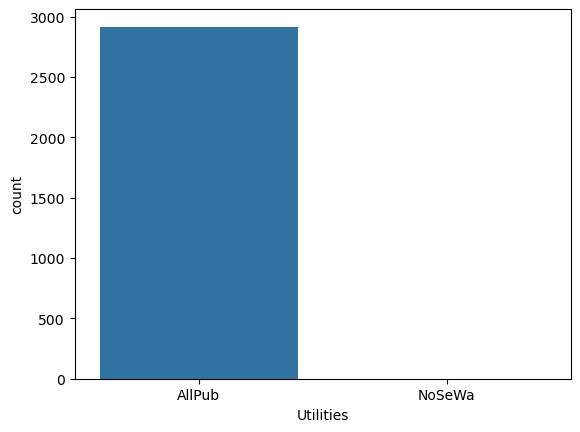

           LotConfig      Ratio
LotConfig                      
Inside          2133  73.072970
Corner           511  17.505995
CulDSac          176   6.029462
FR2               85   2.911956
FR3               14   0.479616
################


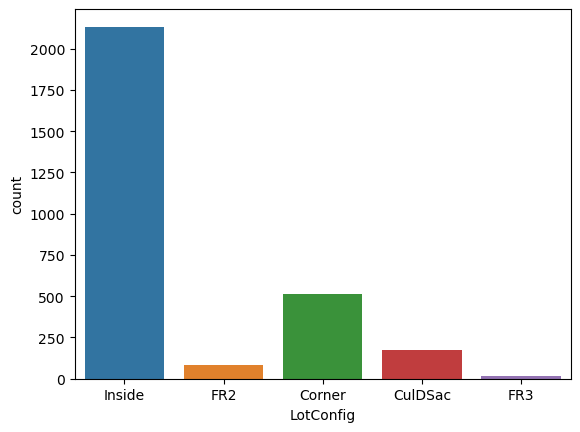

           LandSlope      Ratio
LandSlope                      
Gtl             2778  95.169579
Mod              125   4.282288
Sev               16   0.548133
################


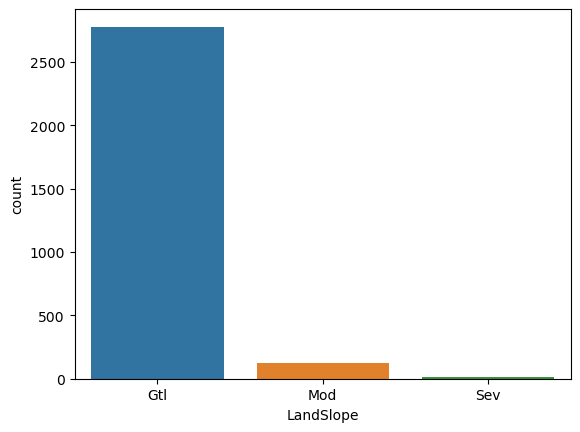

              Neighborhood      Ratio
Neighborhood                         
NAmes                  443  15.176430
CollgCr                267   9.146968
OldTown                239   8.187736
Edwards                194   6.646112
Somerst                182   6.235012
NridgHt                166   5.686879
Gilbert                165   5.652621
Sawyer                 151   5.173004
NWAmes                 131   4.487838
SawyerW                125   4.282288
Mitchel                114   3.905447
BrkSide                108   3.699897
Crawfor                103   3.528606
IDOTRR                  93   3.186023
Timber                  72   2.466598
NoRidge                 71   2.432340
StoneBr                 51   1.747174
SWISU                   48   1.644399
ClearCr                 44   1.507366
MeadowV                 37   1.267557
BrDale                  30   1.027749
Blmngtn                 28   0.959233
Veenker                 24   0.822199
NPkVill                 23   0.787941
Blueste     

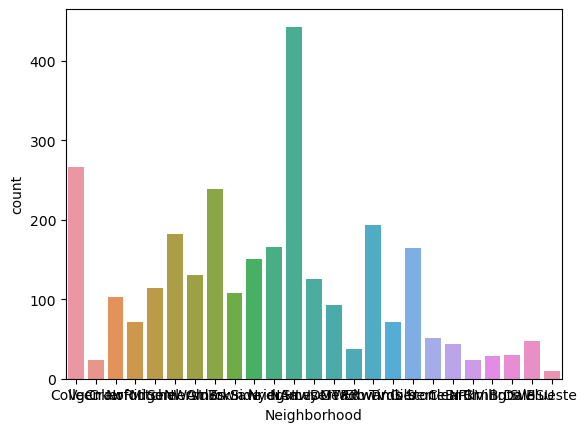

            Condition1      Ratio
Condition1                       
Norm              2511  86.022610
Feedr              164   5.618362
Artery              92   3.151764
RRAn                50   1.712915
PosN                39   1.336074
RRAe                28   0.959233
PosA                20   0.685166
RRNn                 9   0.308325
RRNe                 6   0.205550
################


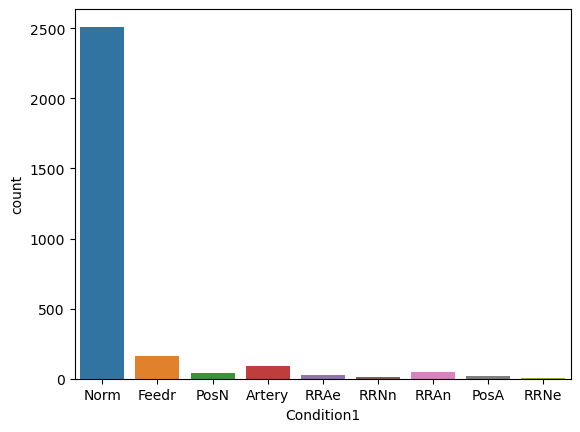

            Condition2      Ratio
Condition2                       
Norm              2889  98.972251
Feedr               13   0.445358
Artery               5   0.171292
PosN                 4   0.137033
PosA                 4   0.137033
RRNn                 2   0.068517
RRAn                 1   0.034258
RRAe                 1   0.034258
################


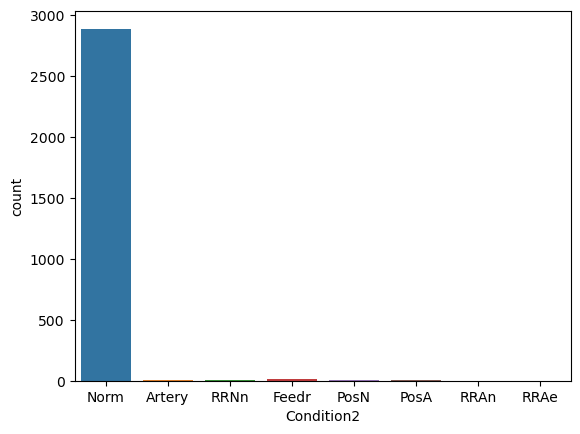

          BldgType      Ratio
BldgType                     
1Fam          2425  83.076396
TwnhsE         227   7.776636
Duplex         109   3.734156
Twnhs           96   3.288798
2fmCon          62   2.124015
################


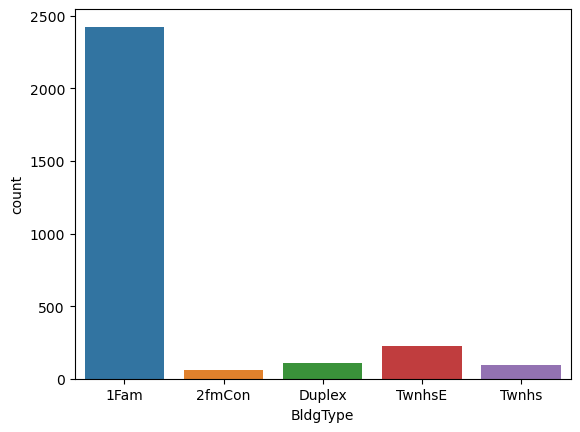

            HouseStyle      Ratio
HouseStyle                       
1Story            1471  50.393971
2Story             872  29.873244
1.5Fin             314  10.757109
SLvl               128   4.385063
SFoyer              83   2.843440
2.5Unf              24   0.822199
1.5Unf              19   0.650908
2.5Fin               8   0.274066
################


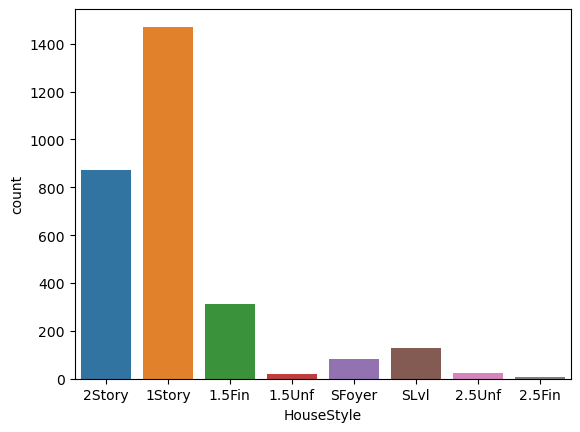

           RoofStyle      Ratio
RoofStyle                      
Gable           2310  79.136691
Hip              551  18.876328
Gambrel           22   0.753683
Flat              20   0.685166
Mansard           11   0.376841
Shed               5   0.171292
################


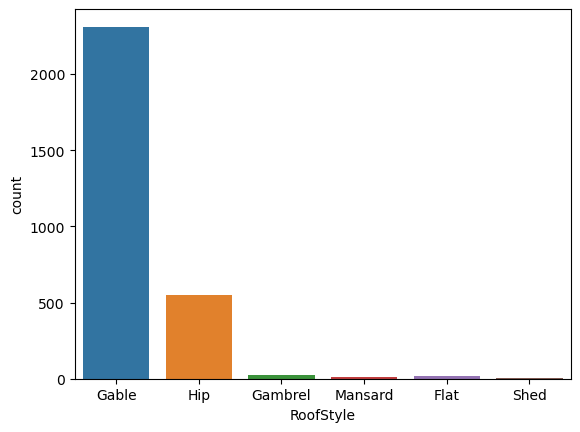

          RoofMatl      Ratio
RoofMatl                     
CompShg       2876  98.526893
Tar&Grv         23   0.787941
WdShake          9   0.308325
WdShngl          7   0.239808
Metal            1   0.034258
Membran          1   0.034258
Roll             1   0.034258
ClyTile          1   0.034258
################


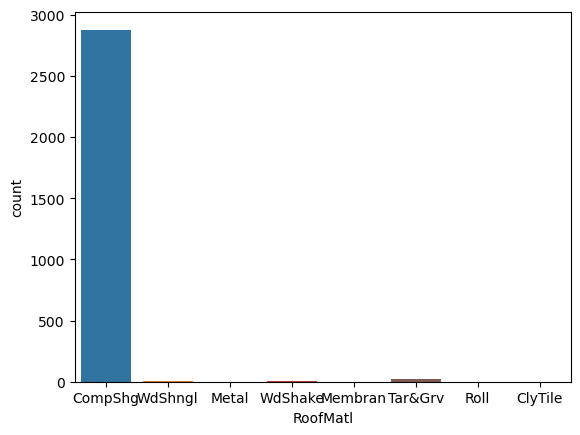

             Exterior1st      Ratio
Exterior1st                        
VinylSd             1025  35.114765
MetalSd              450  15.416238
HdBoard              442  15.142172
Wd Sdng              411  14.080164
Plywood              221   7.571086
CemntBd              126   4.316547
BrkFace               87   2.980473
WdShing               56   1.918465
AsbShng               44   1.507366
Stucco                43   1.473107
BrkComm                6   0.205550
AsphShn                2   0.068517
Stone                  2   0.068517
CBlock                 2   0.068517
ImStucc                1   0.034258
################


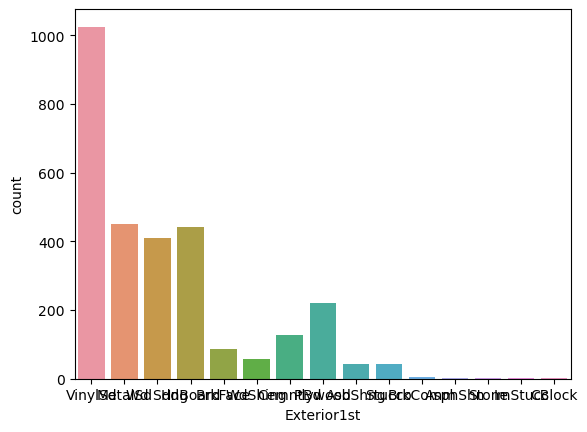

             Exterior2nd      Ratio
Exterior2nd                        
VinylSd             1014  34.737924
MetalSd              447  15.313464
HdBoard              406  13.908873
Wd Sdng              391  13.394998
Plywood              270   9.249743
CmentBd              126   4.316547
Wd Shng               81   2.774923
BrkFace               47   1.610140
Stucco                47   1.610140
AsbShng               38   1.301816
Brk Cmn               22   0.753683
ImStucc               15   0.513875
Stone                  6   0.205550
AsphShn                4   0.137033
CBlock                 3   0.102775
Other                  1   0.034258
################


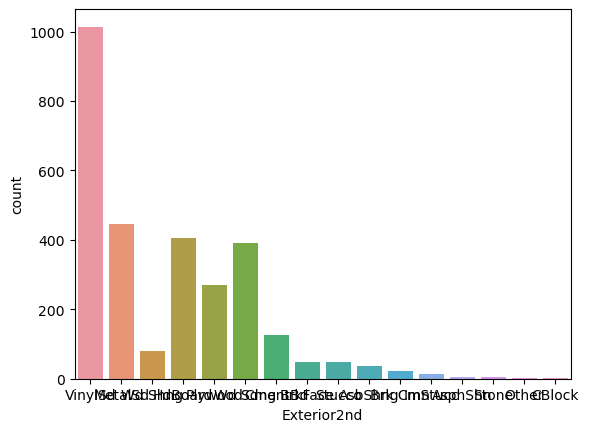

            MasVnrType      Ratio
MasVnrType                       
BrkFace            879  30.113052
Stone              249   8.530319
BrkCmn              25   0.856458
################


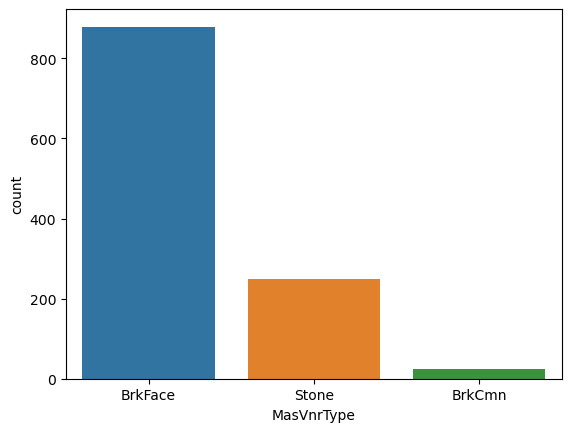

           ExterQual      Ratio
ExterQual                      
TA              1798  61.596437
Gd               979  33.538883
Ex               107   3.665639
Fa                35   1.199041
################


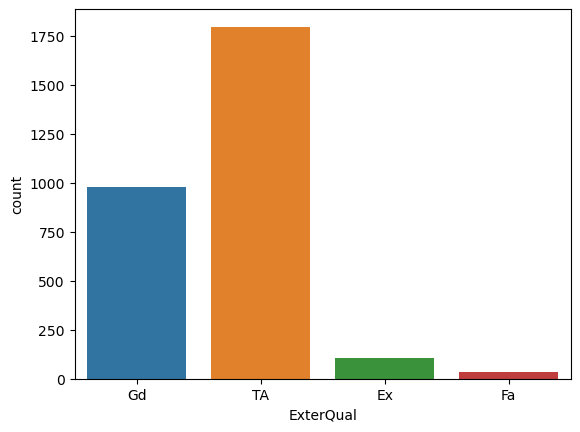

           ExterCond      Ratio
ExterCond                      
TA              2538  86.947585
Gd               299  10.243234
Fa                67   2.295307
Ex                12   0.411100
Po                 3   0.102775
################


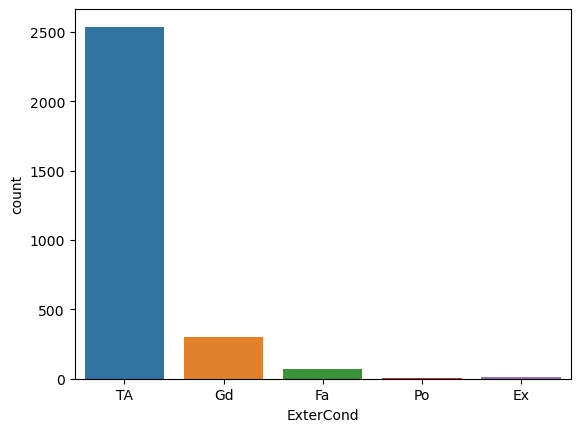

            Foundation      Ratio
Foundation                       
PConc             1308  44.809866
CBlock            1235  42.309010
BrkTil             311  10.654334
Slab                49   1.678657
Stone               11   0.376841
Wood                 5   0.171292
################


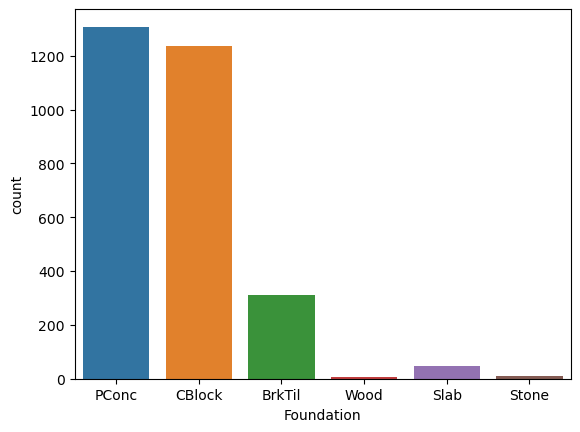

          BsmtQual      Ratio
BsmtQual                     
TA            1283  43.953409
Gd            1209  41.418294
Ex             258   8.838643
Fa              88   3.014731
################


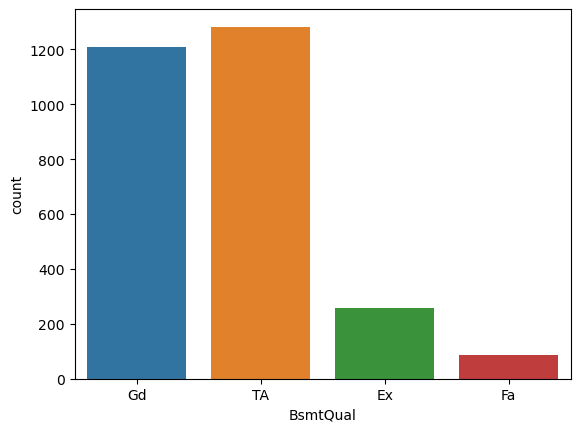

          BsmtCond      Ratio
BsmtCond                     
TA            2606  89.277150
Gd             122   4.179514
Fa             104   3.562864
Po               5   0.171292
################


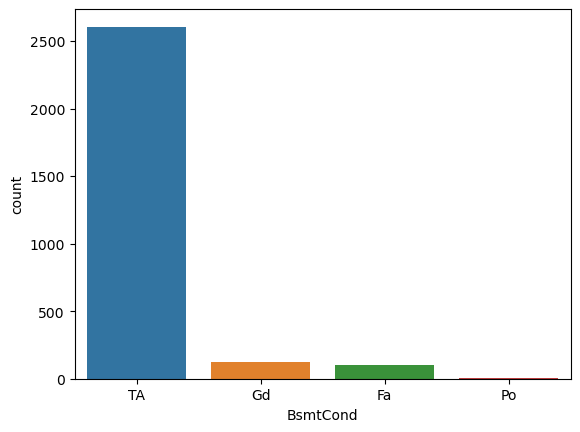

              BsmtExposure      Ratio
BsmtExposure                         
No                    1904  65.227818
Av                     418  14.319973
Gd                     276   9.455293
Mn                     239   8.187736
################


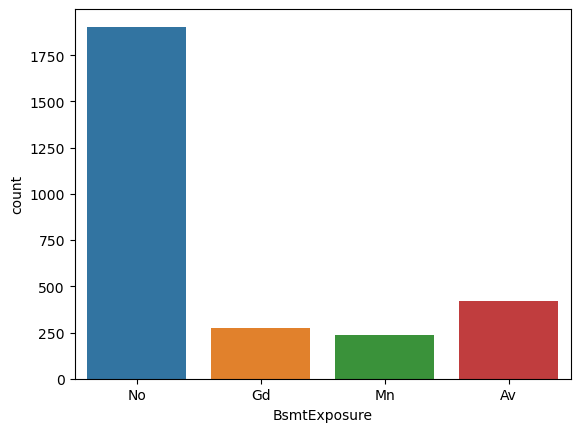

              BsmtFinType1      Ratio
BsmtFinType1                         
Unf                    851  29.153820
GLQ                    849  29.085303
ALQ                    429  14.696814
Rec                    288   9.866393
BLQ                    269   9.215485
LwQ                    154   5.275779
################


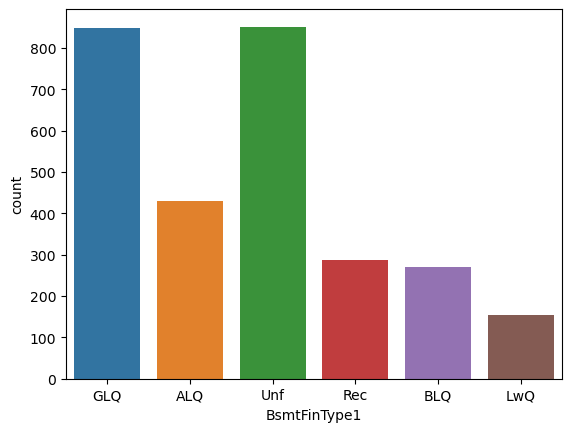

              BsmtFinType2      Ratio
BsmtFinType2                         
Unf                   2493  85.405961
Rec                    105   3.597122
LwQ                     87   2.980473
BLQ                     68   2.329565
ALQ                     52   1.781432
GLQ                     34   1.164782
################


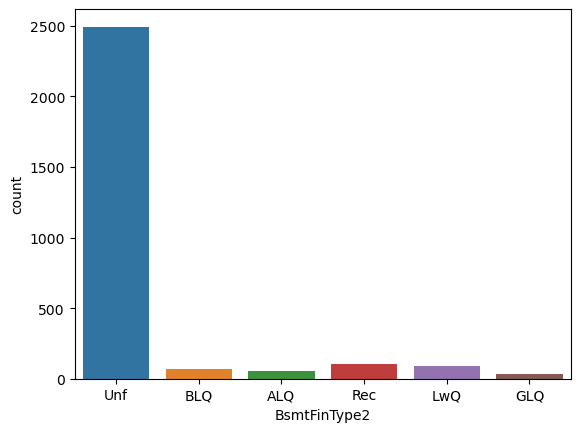

         Heating      Ratio
Heating                    
GasA        2874  98.458376
GasW          27   0.924974
Grav           9   0.308325
Wall           6   0.205550
OthW           2   0.068517
Floor          1   0.034258
################


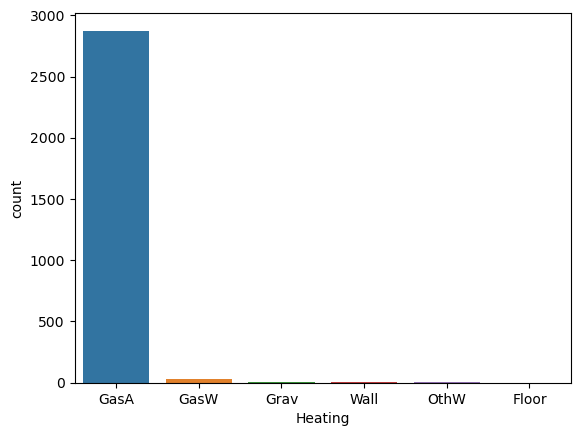

           HeatingQC      Ratio
HeatingQC                      
Ex              1493  51.147653
TA               857  29.359370
Gd               474  16.238438
Fa                92   3.151764
Po                 3   0.102775
################


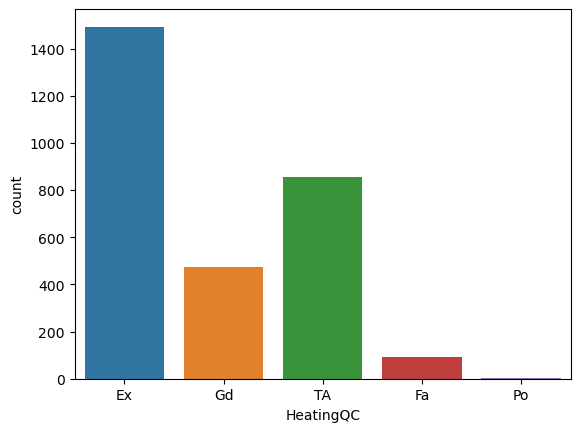

            CentralAir      Ratio
CentralAir                       
Y                 2723  93.285372
N                  196   6.714628
################


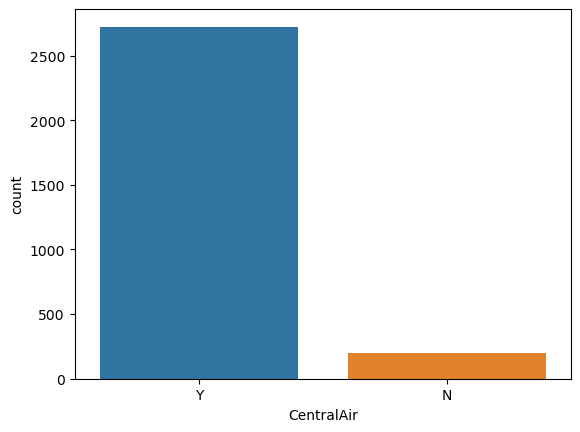

            Electrical      Ratio
Electrical                       
SBrkr             2671  91.503940
FuseA              188   6.440562
FuseF               50   1.712915
FuseP                8   0.274066
Mix                  1   0.034258
################


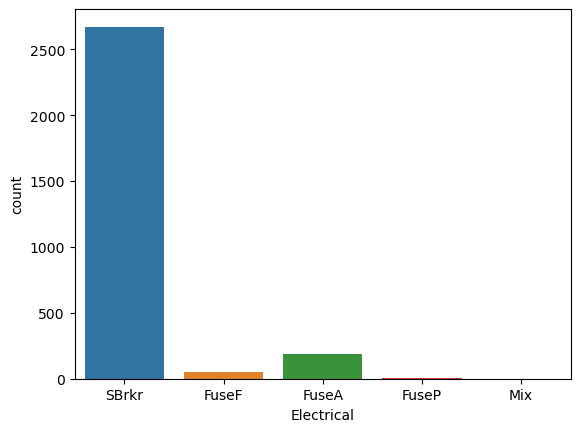

             KitchenQual      Ratio
KitchenQual                        
TA                  1492  51.113395
Gd                  1151  39.431312
Ex                   205   7.022953
Fa                    70   2.398082
################


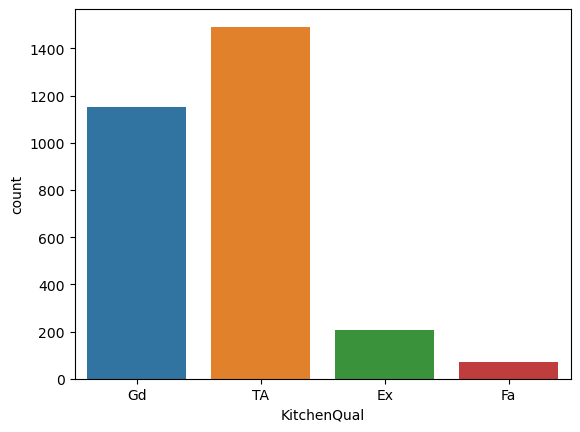

            Functional      Ratio
Functional                       
Typ               2717  93.079822
Min2                70   2.398082
Min1                65   2.226790
Mod                 35   1.199041
Maj1                19   0.650908
Maj2                 9   0.308325
Sev                  2   0.068517
################


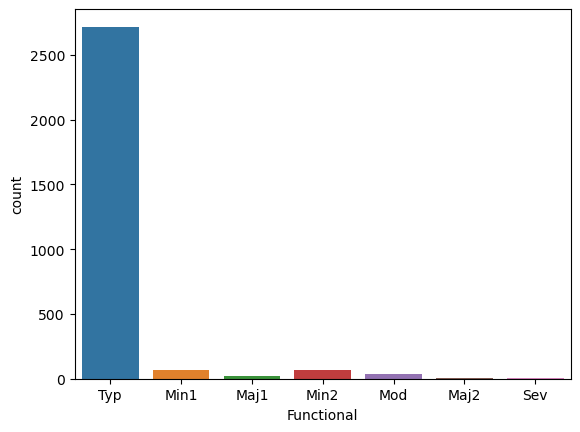

             FireplaceQu      Ratio
FireplaceQu                        
Gd                   744  25.488181
TA                   592  20.280918
Fa                    74   2.535115
Po                    46   1.575882
Ex                    43   1.473107
################


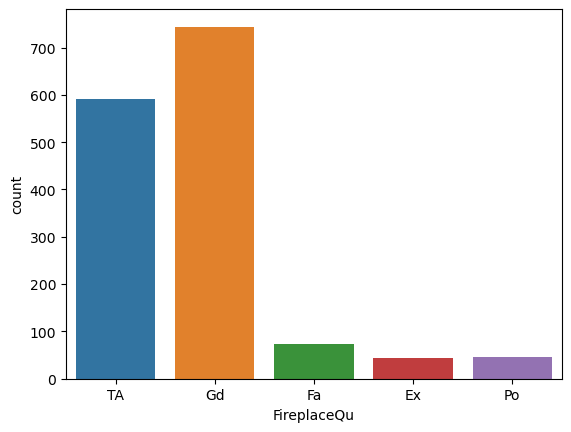

            GarageType      Ratio
GarageType                       
Attchd            1723  59.027064
Detchd             779  26.687222
BuiltIn            186   6.372045
Basment             36   1.233299
2Types              23   0.787941
CarPort             15   0.513875
################


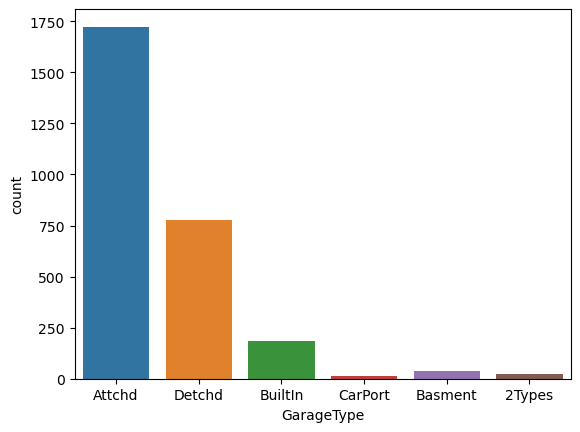

              GarageFinish      Ratio
GarageFinish                         
Unf                   1230  42.137718
RFn                    811  27.783487
Fin                    719  24.631723
################


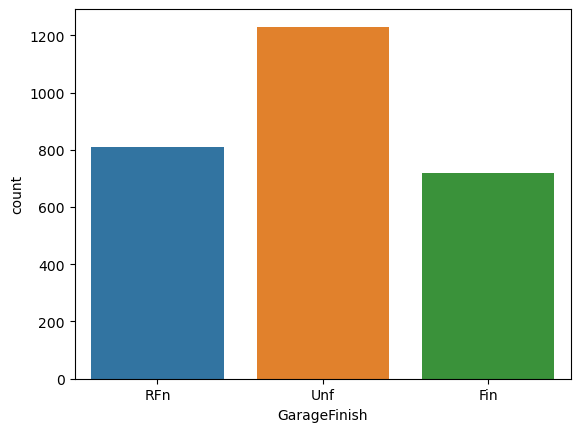

            GarageQual      Ratio
GarageQual                       
TA                2604  89.208633
Fa                 124   4.248030
Gd                  24   0.822199
Po                   5   0.171292
Ex                   3   0.102775
################


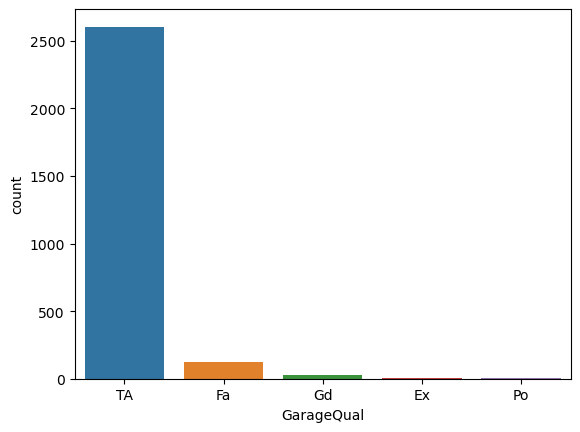

            GarageCond      Ratio
GarageCond                       
TA                2654  90.921548
Fa                  74   2.535115
Gd                  15   0.513875
Po                  14   0.479616
Ex                   3   0.102775
################


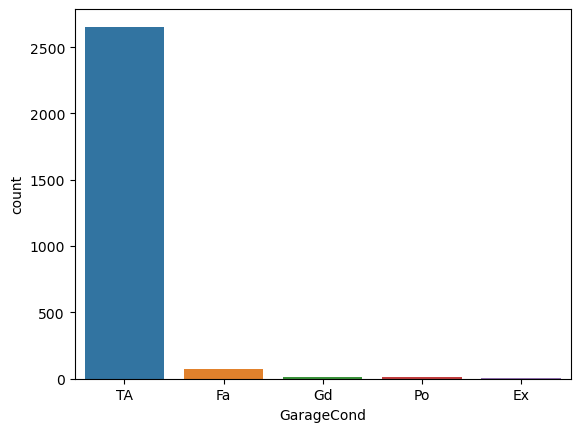

            PavedDrive      Ratio
PavedDrive                       
Y                 2641  90.476190
N                  216   7.399794
P                   62   2.124015
################


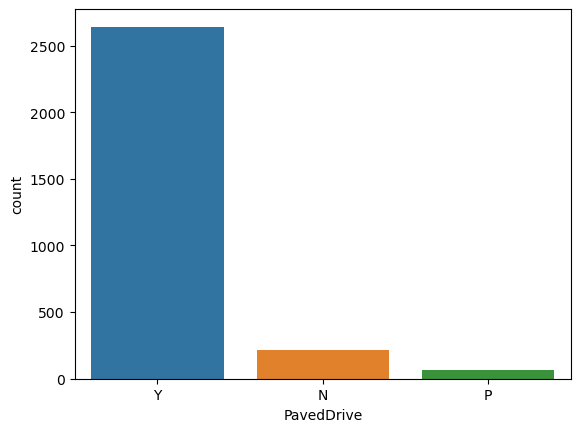

        PoolQC     Ratio
PoolQC                  
Ex           4  0.137033
Gd           4  0.137033
Fa           2  0.068517
################


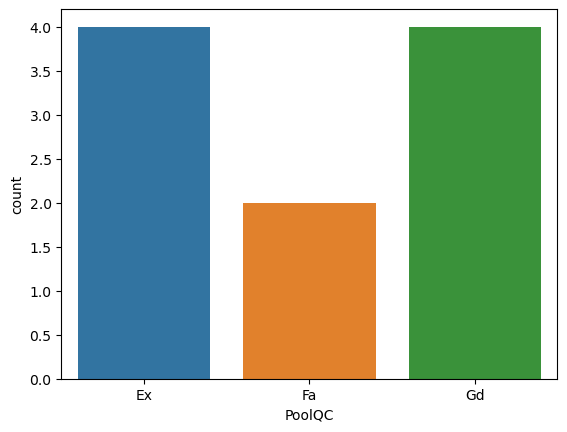

       Fence      Ratio
Fence                  
MnPrv    329  11.270983
GdPrv    118   4.042480
GdWo     112   3.836930
MnWw      12   0.411100
################


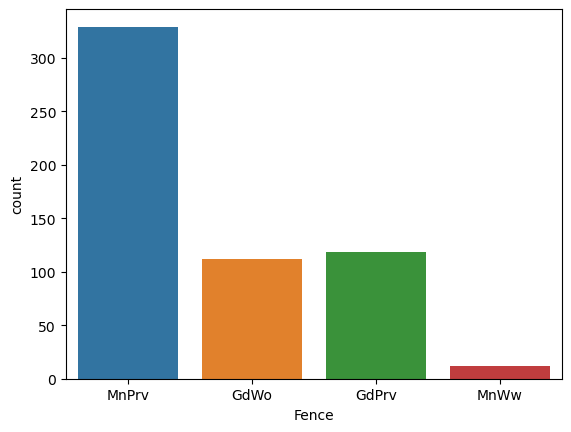

             MiscFeature     Ratio
MiscFeature                       
Shed                  95  3.254539
Gar2                   5  0.171292
Othr                   4  0.137033
TenC                   1  0.034258
################


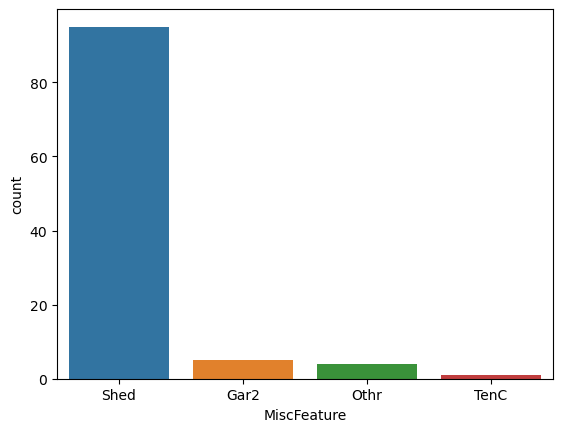

          SaleType      Ratio
SaleType                     
WD            2525  86.502227
New            239   8.187736
COD             87   2.980473
ConLD           26   0.890716
CWD             12   0.411100
ConLI            9   0.308325
ConLw            8   0.274066
Oth              7   0.239808
Con              5   0.171292
################


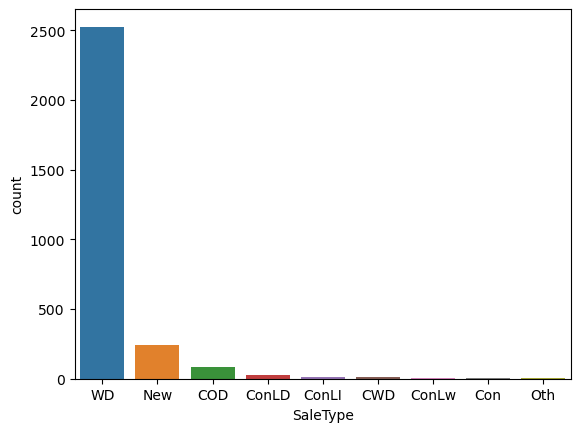

               SaleCondition      Ratio
SaleCondition                          
Normal                  2402  82.288455
Partial                  245   8.393285
Abnorml                  190   6.509078
Family                    46   1.575882
Alloca                    24   0.822199
AdjLand                   12   0.411100
################


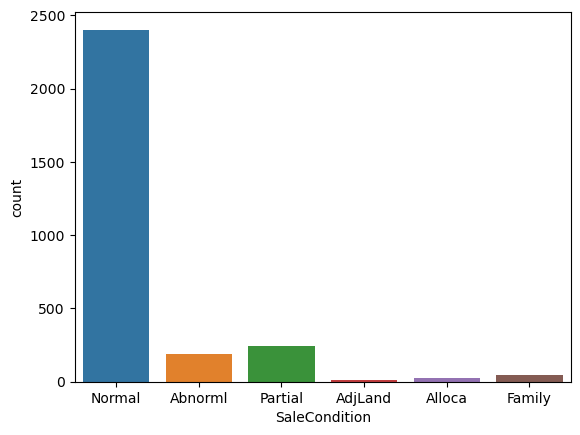

             OverallCond      Ratio
OverallCond                        
5                   1645  56.354916
6                    531  18.191161
7                    390  13.360740
8                    144   4.933196
4                    101   3.460089
3                     50   1.712915
9                     41   1.404591
2                     10   0.342583
1                      7   0.239808
################


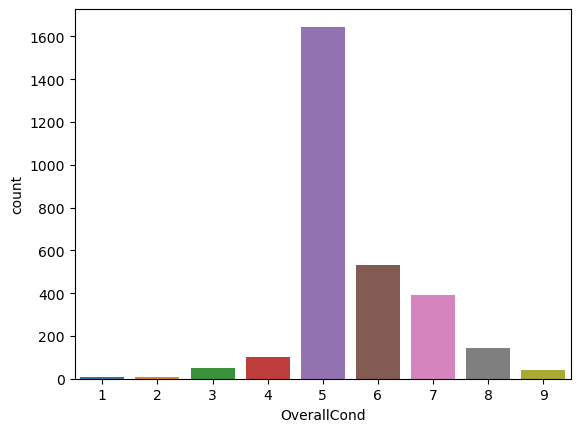

              BsmtFullBath      Ratio
BsmtFullBath                         
0.0                   1705  58.410415
1.0                   1172  40.150737
2.0                     38   1.301816
3.0                      2   0.068517
################


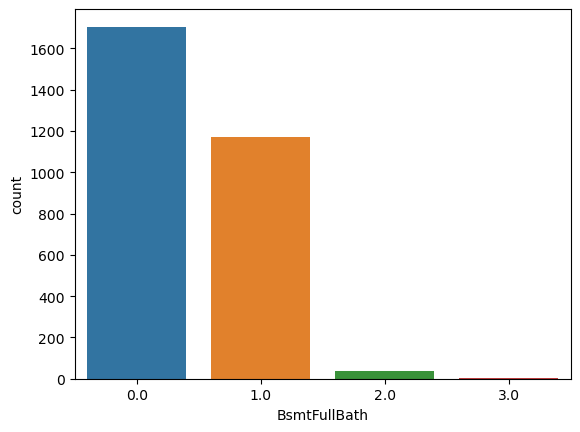

              BsmtHalfBath      Ratio
BsmtHalfBath                         
0.0                   2742  93.936280
1.0                    171   5.858171
2.0                      4   0.137033
################


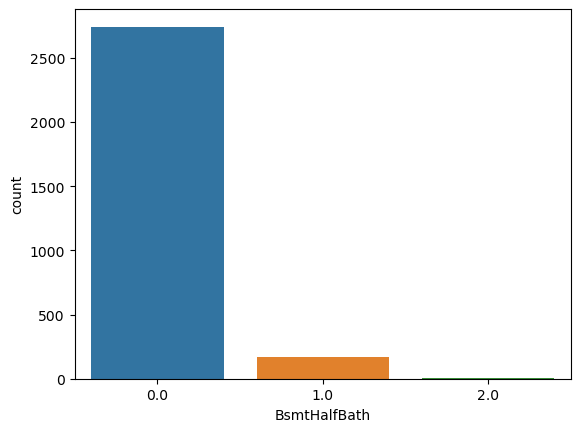

          FullBath      Ratio
FullBath                     
2             1530  52.415211
1             1309  44.844125
3               64   2.192532
0               12   0.411100
4                4   0.137033
################


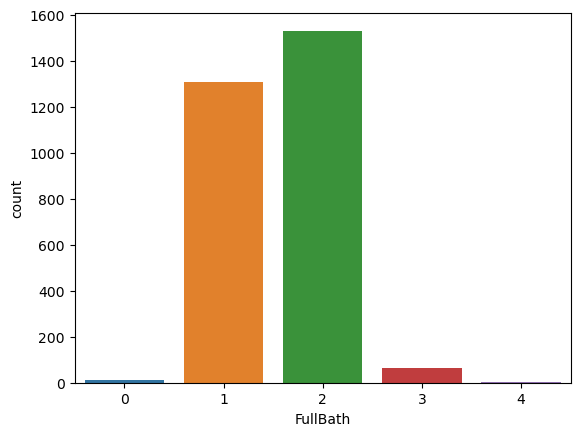

          HalfBath      Ratio
HalfBath                     
0             1834  62.829736
1             1060  36.313806
2               25   0.856458
################


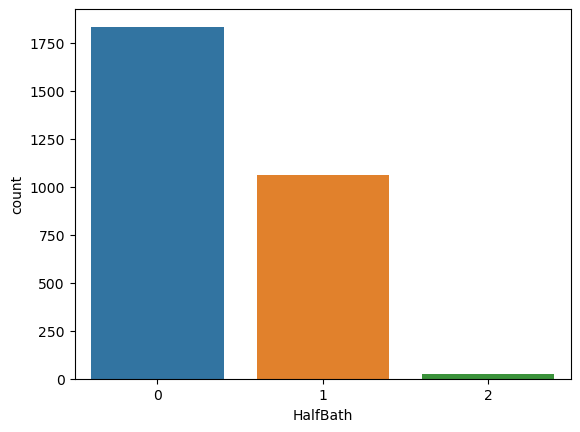

              BedroomAbvGr      Ratio
BedroomAbvGr                         
3                     1596  54.676259
2                      742  25.419664
4                      400  13.703323
1                      103   3.528606
5                       48   1.644399
6                       21   0.719424
0                        8   0.274066
8                        1   0.034258
################


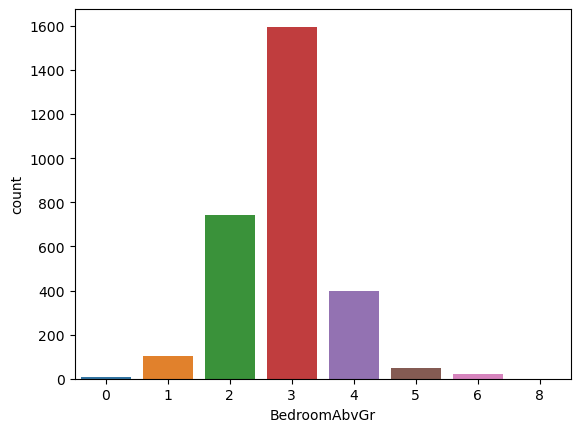

              KitchenAbvGr      Ratio
KitchenAbvGr                         
1                     2785  95.409387
2                      129   4.419322
0                        3   0.102775
3                        2   0.068517
################


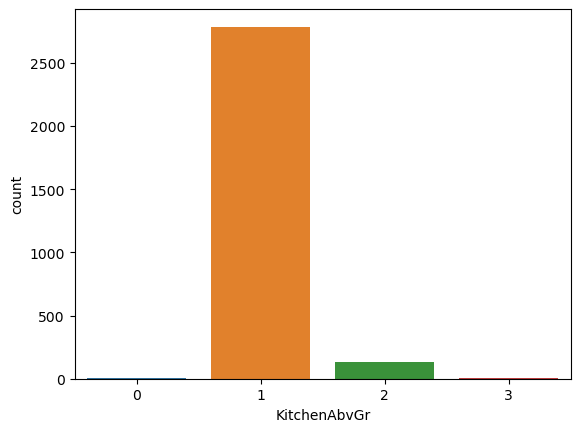

            Fireplaces      Ratio
Fireplaces                       
0                 1420  48.646797
1                 1268  43.439534
2                  219   7.502569
3                   11   0.376841
4                    1   0.034258
################


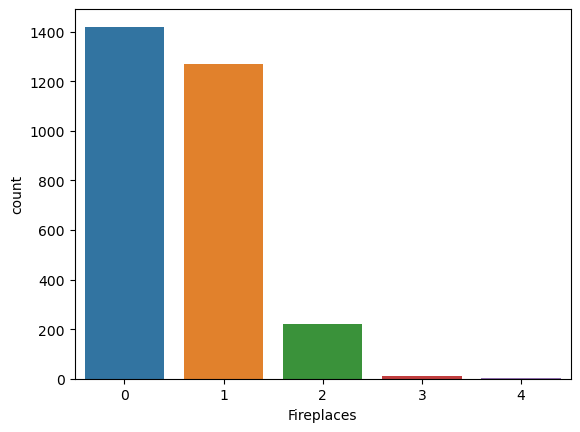

            GarageCars      Ratio
GarageCars                       
2.0               1594  54.607742
1.0                776  26.584447
3.0                374  12.812607
0.0                157   5.378554
4.0                 16   0.548133
5.0                  1   0.034258
################


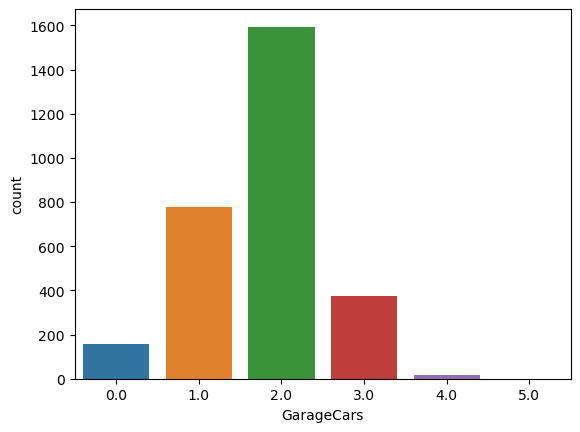

        YrSold      Ratio
YrSold                   
2007       692  23.706749
2009       647  22.165125
2008       622  21.308667
2006       619  21.205892
2010       339  11.613566
################


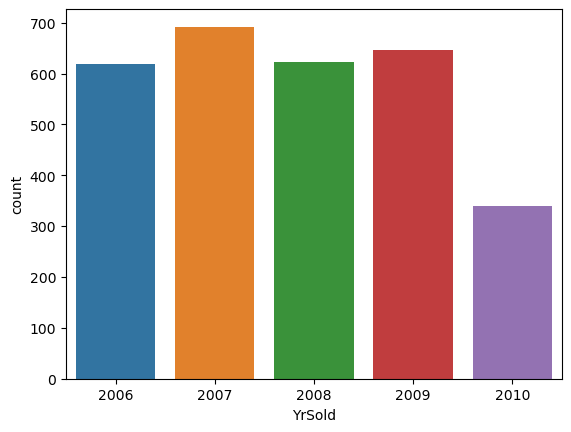

In [12]:
for col in cat_cols:
    cat_summary(df, col, True)

In [13]:
###################################
# ANALYSIS OF NUMERICAL VARIABLES
##################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64


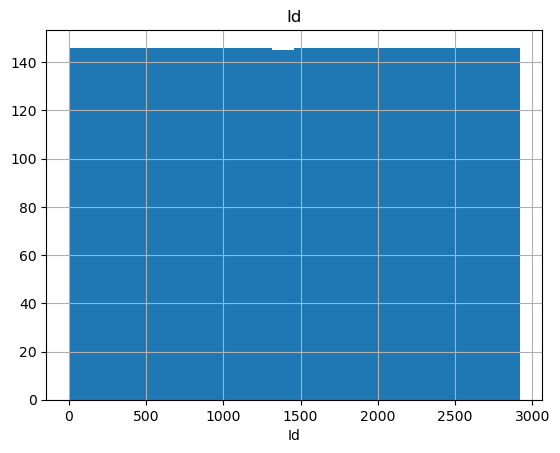

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


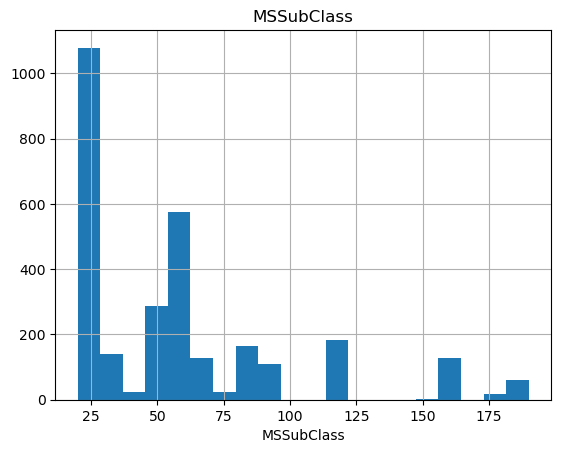

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


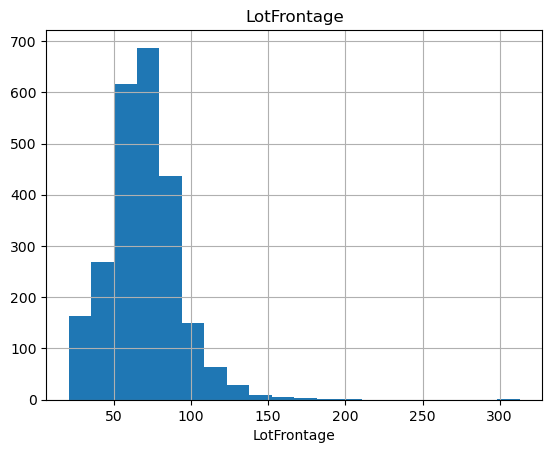

count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
20%        7007.600000
30%        7960.400000
40%        8741.000000
50%        9453.000000
60%       10151.600000
70%       11001.200000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


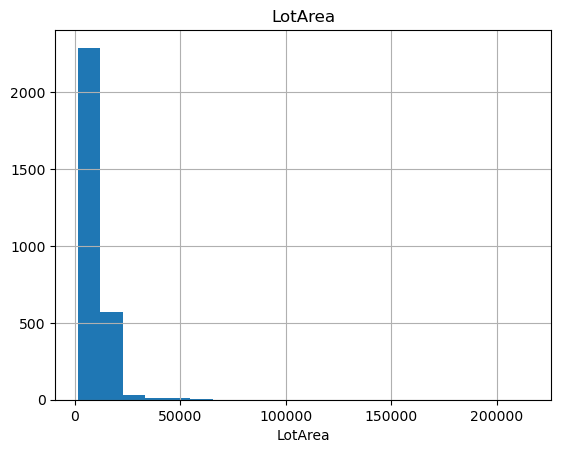

count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


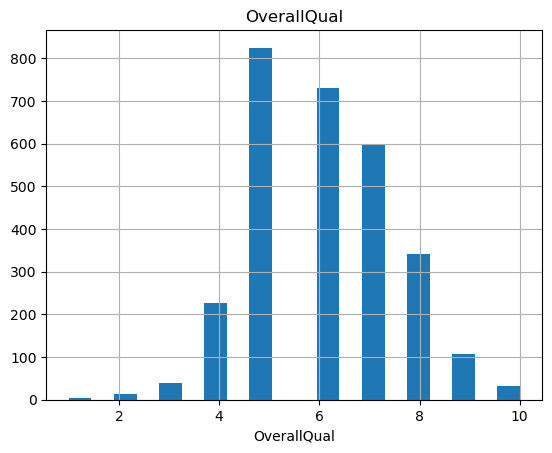

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


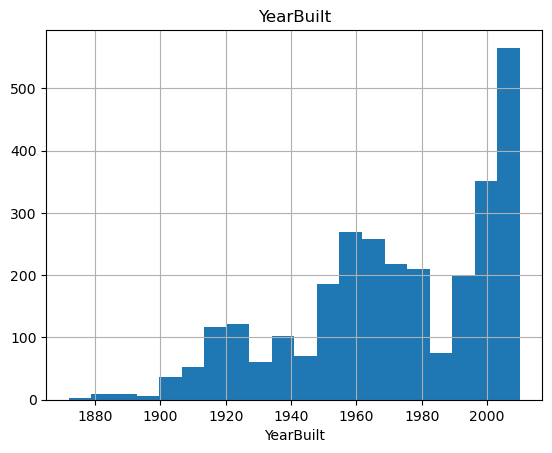

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


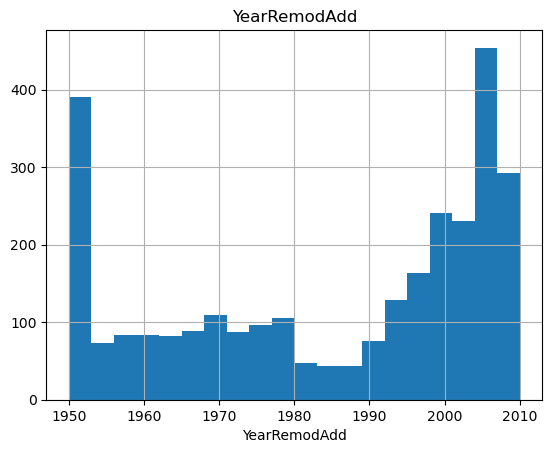

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


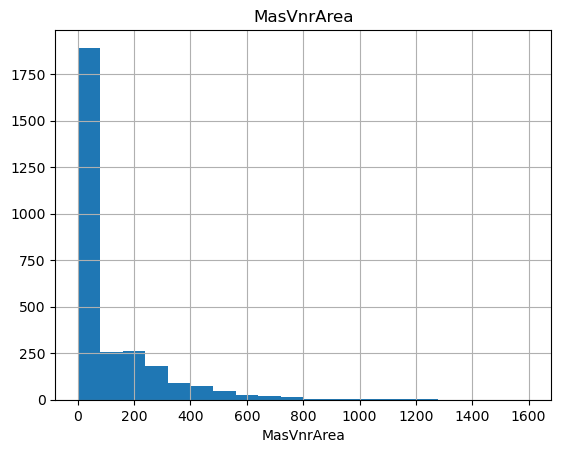

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


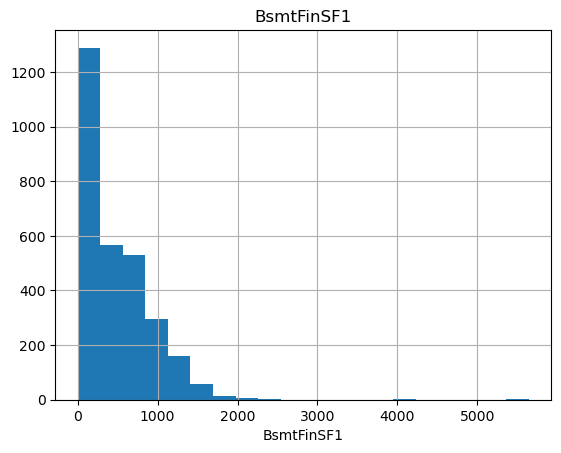

count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


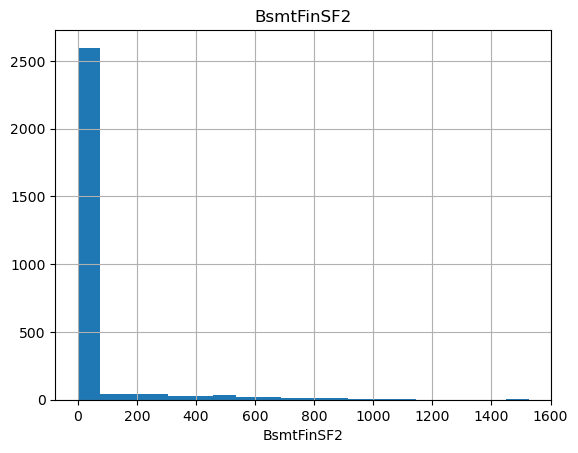

count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


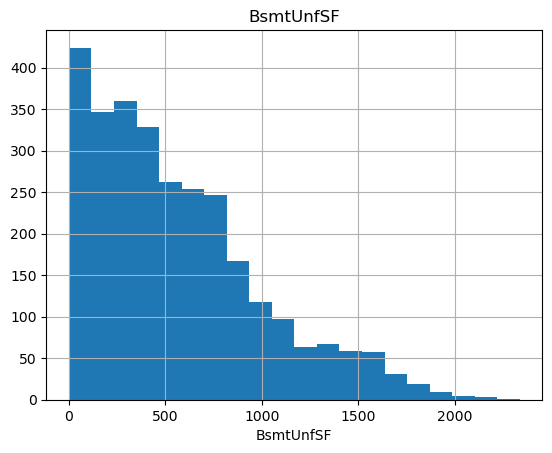

count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


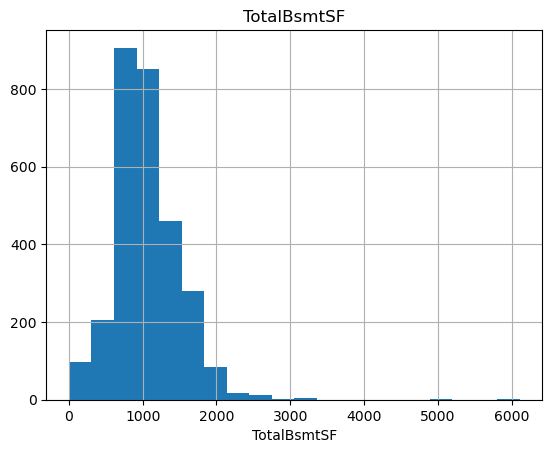

count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


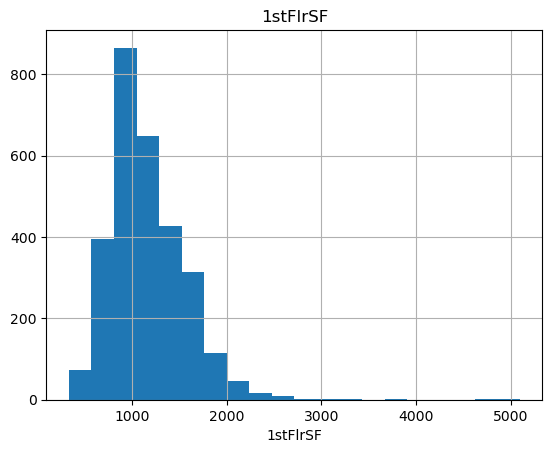

count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


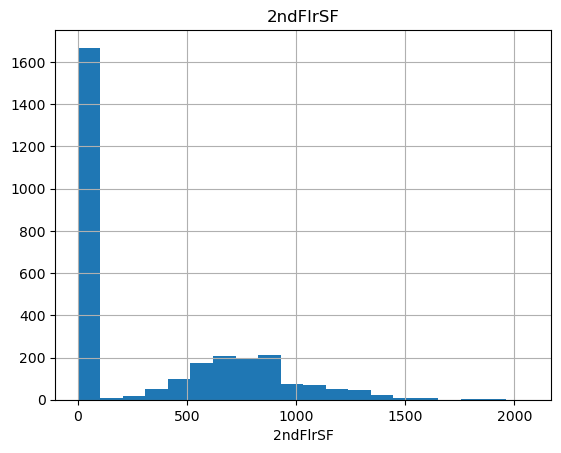

count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


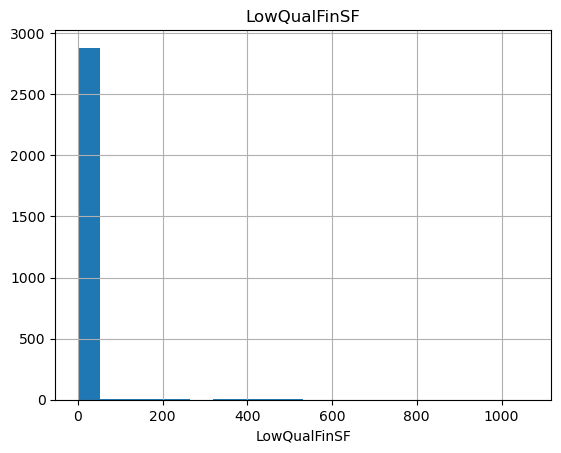

count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


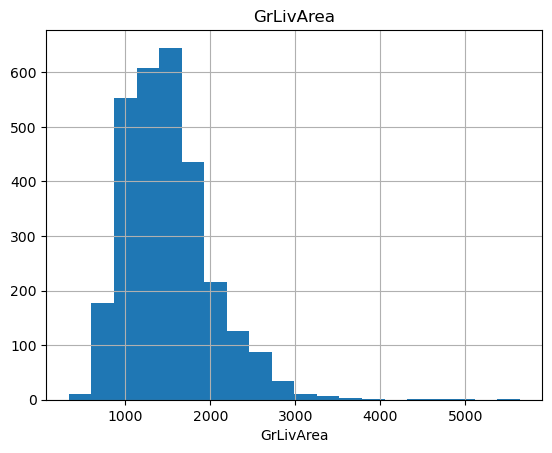

count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         6.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


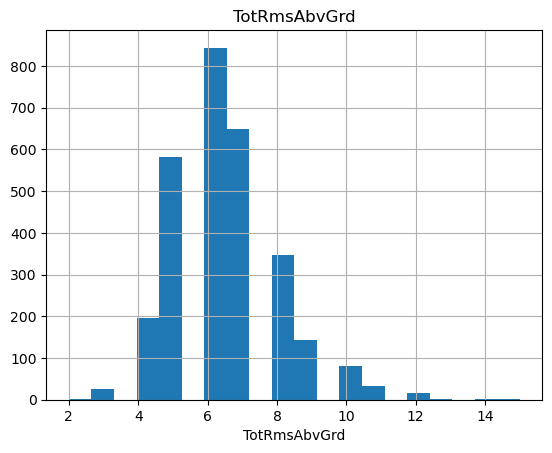

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


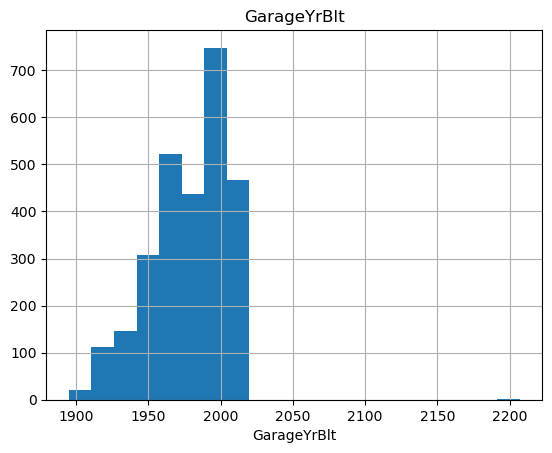

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


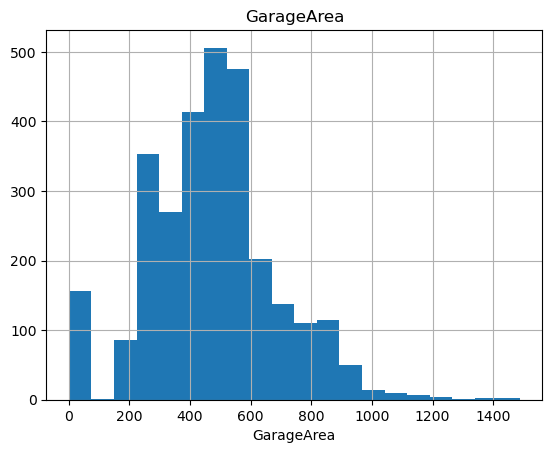

count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


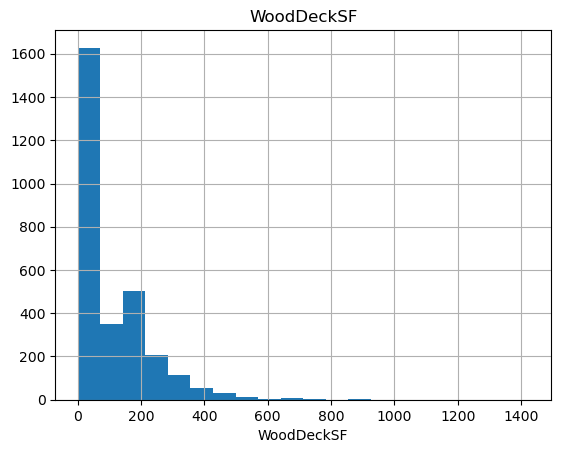

count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


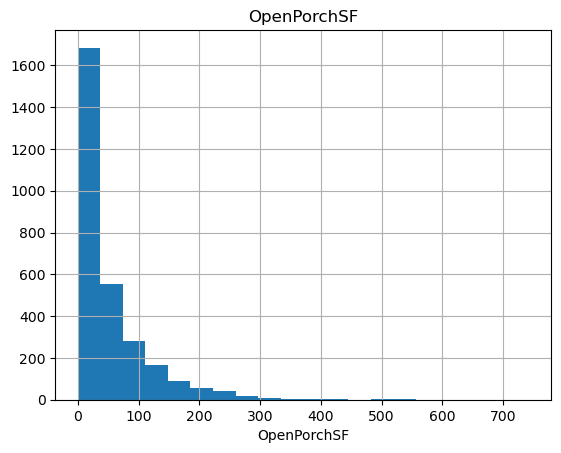

count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


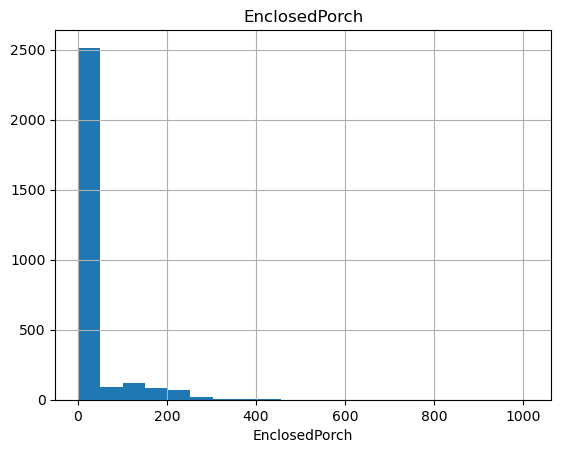

count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


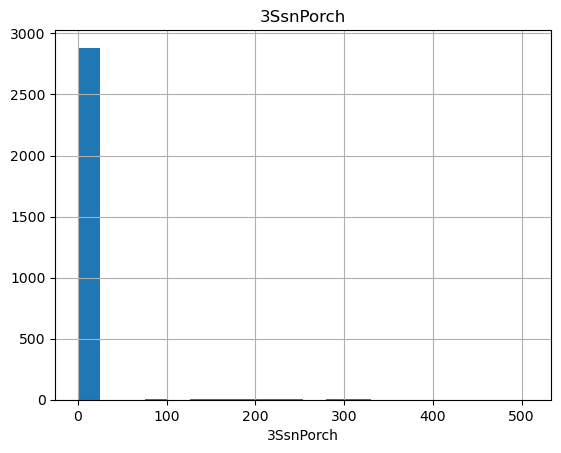

count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


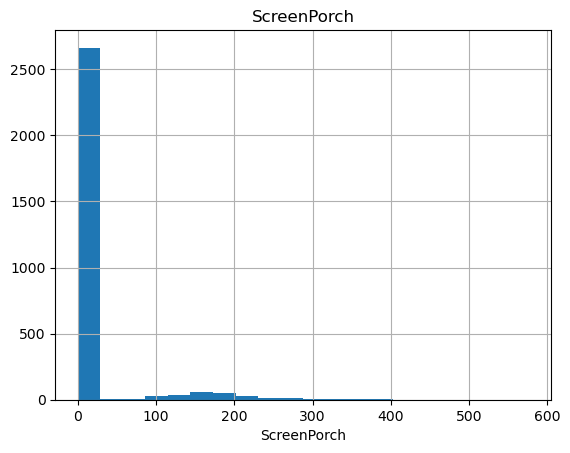

count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


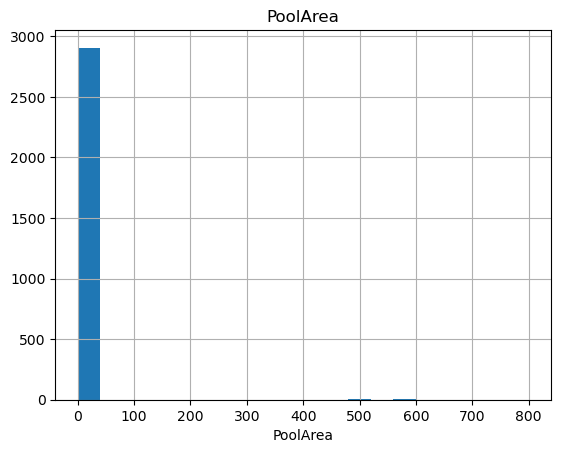

count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


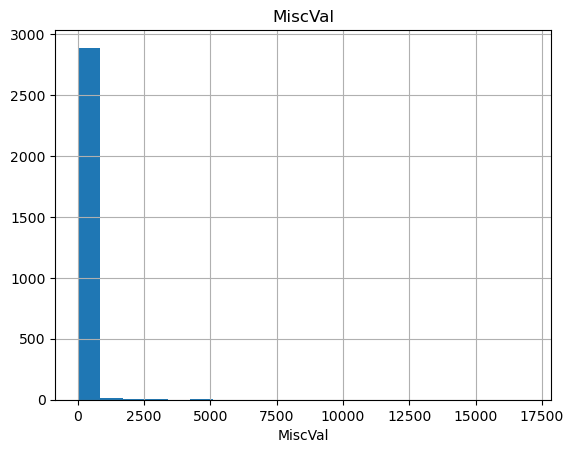

count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
10%         3.000000
20%         4.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


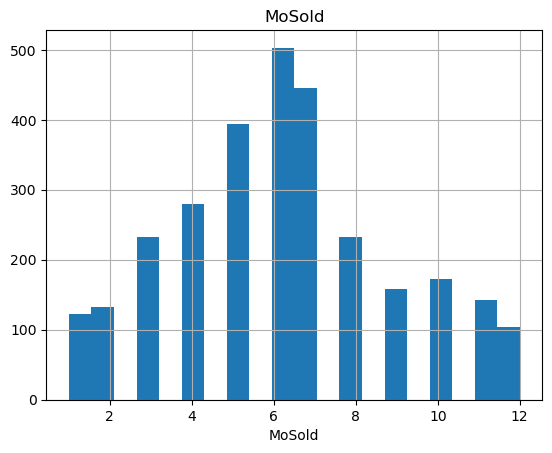

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


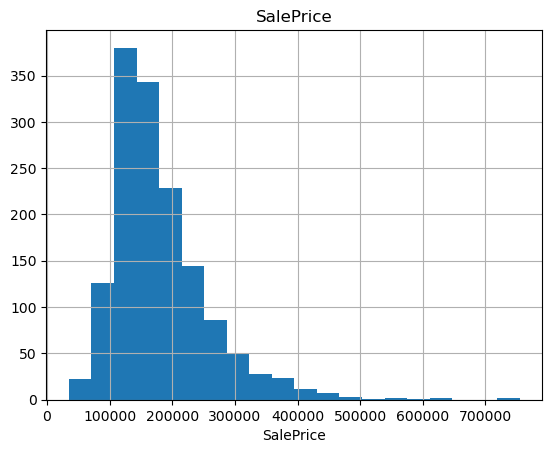

In [14]:
for col in num_cols:
    num_summary(df, col, True)

In [15]:
# Target variable analysis with graphs

def target_summary_with_cat(dataframe, target, col_name):
    print(pd.DataFrame({"Taget Mean": dataframe.groupby(col_name)[target].mean()}))
for col in cat_cols:
    target_summary_with_cat(df, "SalePrice",col)

             Taget Mean
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275
           Taget Mean
Street               
Grvl    130190.500000
Pave    181130.538514
          Taget Mean
Alley               
Grvl   122219.080000
Pave   168000.585366
             Taget Mean
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378
                Taget Mean
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758
             Taget Mean
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000
              Taget Mean
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529
              Taget Mean
LandSlope               
Gtl        179956.799566
Mod     

In [16]:
# Target variable analysis according to numerical variables
def target_summary_with_num(dataframe, target, numeric_col):
    print(dataframe.groupby(target).agg({numeric_col: "mean"}),end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df,"SalePrice", col)

               Id
SalePrice        
34900.0     496.0
35311.0     917.0
37900.0     969.0
39300.0     534.0
40000.0      31.0
...           ...
582933.0    804.0
611657.0    899.0
625000.0   1170.0
745000.0   1183.0
755000.0    692.0

[663 rows x 1 columns]


           MSSubClass
SalePrice            
34900.0          30.0
35311.0          20.0
37900.0          50.0
39300.0          20.0
40000.0          70.0
...               ...
582933.0         60.0
611657.0         20.0
625000.0         60.0
745000.0         60.0
755000.0         60.0

[663 rows x 1 columns]


           LotFrontage
SalePrice             
34900.0           60.0
35311.0           50.0
37900.0           50.0
39300.0           50.0
40000.0           50.0
...                ...
582933.0         107.0
611657.0         100.0
625000.0         118.0
745000.0         160.0
755000.0         104.0

[663 rows x 1 columns]


           LotArea
SalePrice         
34900.0     7879.0
35311.0     9000.0
37900.0     5925.0
39300.0 

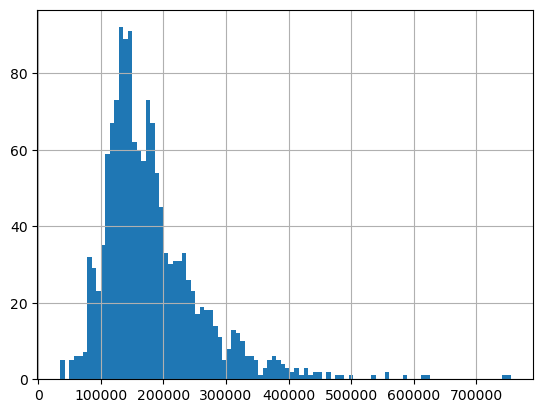

In [17]:
# Examining the dependent variable on the histogram chart

df["SalePrice"].hist(bins=100)
plt.show(block=True)

##### 4.1.1 Correlation Analysis

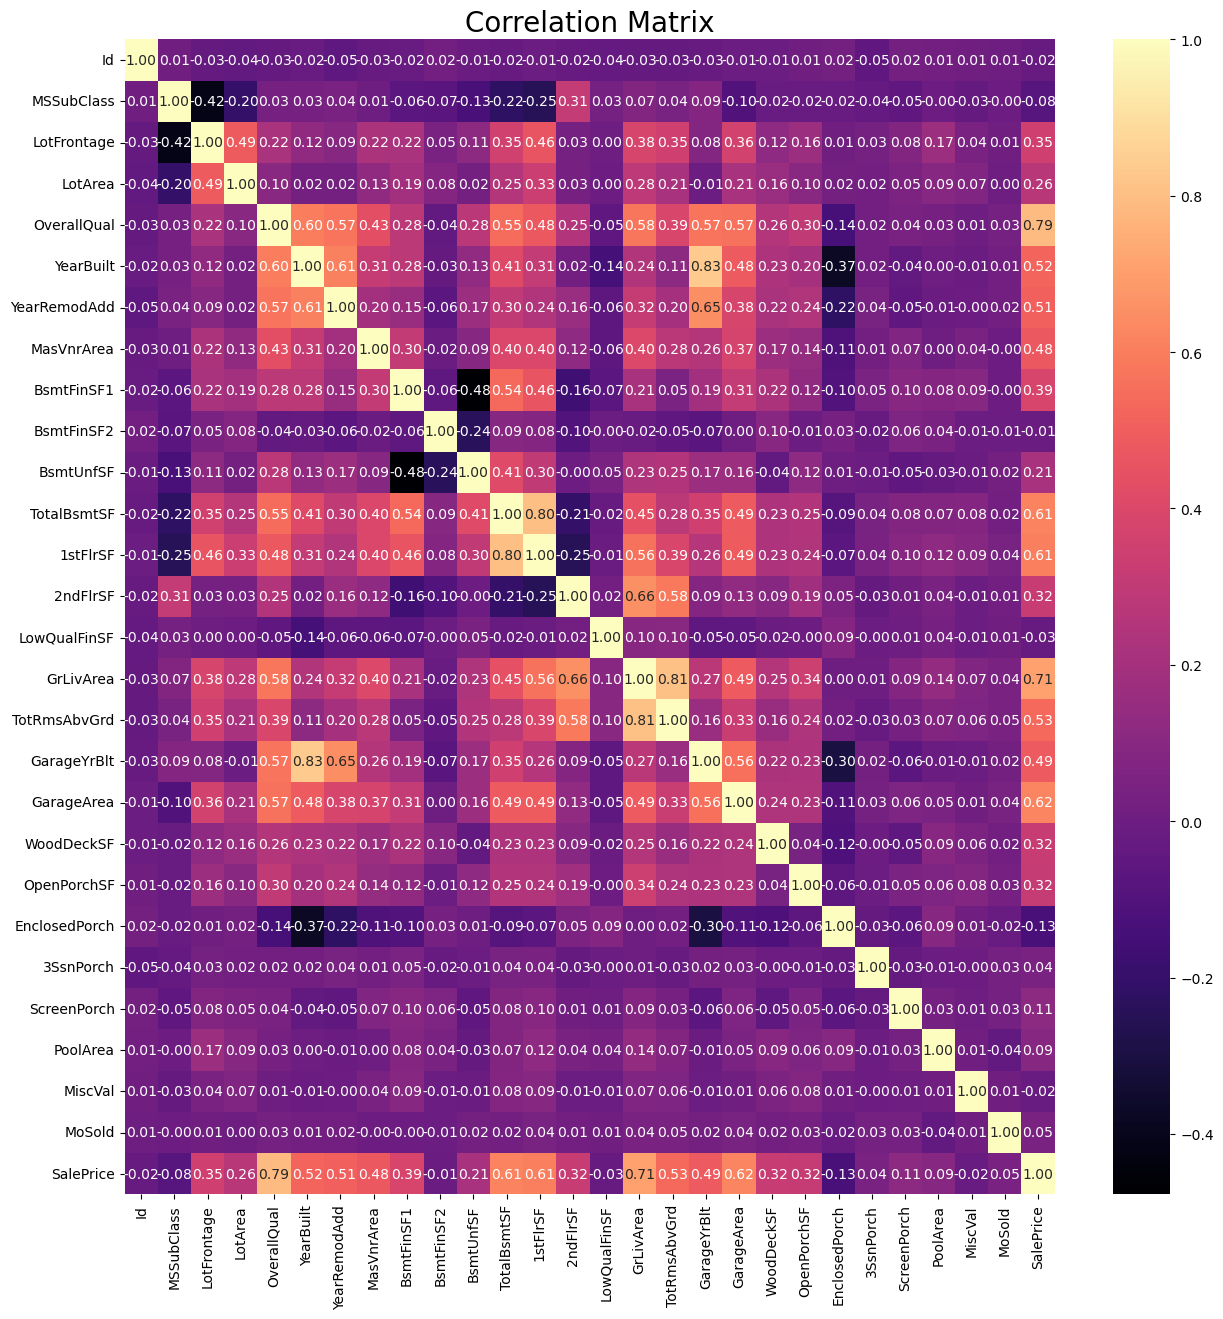

In [18]:
df[num_cols].corr()
f, ax = plt.subplots(figsize=[15,15])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

###### 4.1.2 The Missing Values Analysis

In [19]:
def missin_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [20]:
missin_values_table(df, True)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SalePrice']

In [21]:
na_cols = missin_values_table(df, True)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [22]:
# Analysis of missing values by dependent variable
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)  # Eksik değerler 1 dolu olanlar 0

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "COUNT": temp_df.groupby(col)[target].count()}), end="\n\n\n")



missing_vs_target(df,"SalePrice", na_cols)

                   TARGET_MEAN  COUNT
MSZoning_NA_FLAG                     
0                 180921.19589   1460
1                          NaN      0


                       TARGET_MEAN  COUNT
LotFrontage_NA_FLAG                      
0                    180770.480433   1201
1                    181620.073359    259


                 TARGET_MEAN  COUNT
Alley_NA_FLAG                      
0              142845.912088     91
1              183452.131483   1369


                    TARGET_MEAN  COUNT
Utilities_NA_FLAG                     
0                  180921.19589   1460
1                           NaN      0


                      TARGET_MEAN  COUNT
Exterior1st_NA_FLAG                     
0                    180921.19589   1460
1                             NaN      0


                      TARGET_MEAN  COUNT
Exterior2nd_NA_FLAG                     
0                    180921.19589   1460
1                             NaN      0


                      TARGET_MEAN  COUNT

In [23]:
# Filling in missing data

# We filled Object with None
none_col = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
          "BsmtQual","GarageCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]

In [24]:
for col in none_col:
   df[col] = df[col].fillna("None")

In [25]:
# Filling numeric variables with 0
zero_col = ["GarageYrBlt","GarageArea","GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath",
             "BsmtHalfBath","MasVnrArea", "LotFrontage"]

for col in zero_col:
    df[col] = df[col].fillna(0)

In [26]:
mod_col = ["Electrical","KitchenQual","Exterior2nd","SaleType", "Functional","Exterior1st", "MSZoning"]

for col in mod_col:
    df[col] = df[col].fillna(df[col].mode()[0])

In [27]:
# Checked again for missing values.Null observations in SalePrice are blank values from the test data set.
# We will remove this part during the modeling phase
missin_values_table(df, True)

           n_miss  ratio
SalePrice    1459  49.98
Utilities       2   0.07


['Utilities', 'SalePrice']

###### 4.1.3 Rare Encoder

In [28]:
# Examining the distribution of categorical columns
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT     RATIO    TARGET_MEAN
MSZoning                                
C (all)      25  0.008565   74528.000000
FV          139  0.047619  214014.061538
RH           26  0.008907  131558.375000
RL         2269  0.777321  191004.994787
RM          460  0.157588  126316.830275


Street : 2
        COUNT     RATIO    TARGET_MEAN
Street                                
Grvl       12  0.004111  130190.500000
Pave     2907  0.995889  181130.538514


Alley : 3
       COUNT     RATIO    TARGET_MEAN
Alley                                
Grvl     120  0.041110  122219.080000
None    2721  0.932169  183452.131483
Pave      78  0.026721  168000.585366


LotShape : 4
          COUNT     RATIO    TARGET_MEAN
LotShape                                
IR1         968  0.331620  206101.665289
IR2          76  0.026036  239833.365854
IR3          16  0.005481  216036.500000
Reg        1859  0.636862  164754.818378


LandContour : 4
             COUNT     RATIO    TARGET_MEAN
LandCo

              COUNT     RATIO    TARGET_MEAN
BsmtFinType2                                
ALQ              52  0.017814  209942.105263
BLQ              68  0.023296  151101.000000
GLQ              34  0.011648  180982.142857
LwQ              87  0.029805  164364.130435
None             80  0.027407  110346.236842
Rec             105  0.035971  164917.129630
Unf            2493  0.854060  184694.690287


Heating : 6
         COUNT     RATIO    TARGET_MEAN
Heating                                
Floor        1  0.000343   72500.000000
GasA      2874  0.984584  182021.195378
GasW        27  0.009250  166632.166667
Grav         9  0.003083   75271.428571
OthW         2  0.000685  125750.000000
Wall         6  0.002055   92100.000000


HeatingQC : 5
           COUNT     RATIO    TARGET_MEAN
HeatingQC                                
Ex          1493  0.511477  214914.429150
Fa            92  0.031518  123919.489796
Gd           474  0.162384  156858.871369
Po             3  0.001028   87000.

In [29]:
# Detection of rare classes

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.01)

In [30]:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT     RATIO    TARGET_MEAN
MSZoning                                
C (all)      25  0.008565   74528.000000
FV          139  0.047619  214014.061538
RH           26  0.008907  131558.375000
RL         2269  0.777321  191004.994787
RM          460  0.157588  126316.830275


Street : 2
        COUNT     RATIO    TARGET_MEAN
Street                                
Grvl       12  0.004111  130190.500000
Pave     2907  0.995889  181130.538514


Alley : 3
       COUNT     RATIO    TARGET_MEAN
Alley                                
Grvl     120  0.041110  122219.080000
None    2721  0.932169  183452.131483
Pave      78  0.026721  168000.585366


LotShape : 4
          COUNT     RATIO    TARGET_MEAN
LotShape                                
IR1         968  0.331620  206101.665289
IR2          76  0.026036  239833.365854
IR3          16  0.005481  216036.500000
Reg        1859  0.636862  164754.818378


LandContour : 4
             COUNT     RATIO    TARGET_MEAN
LandCo

##### 4.1.4 Outliers Analysis

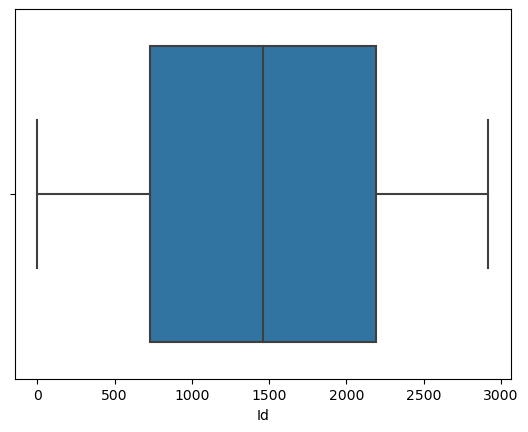

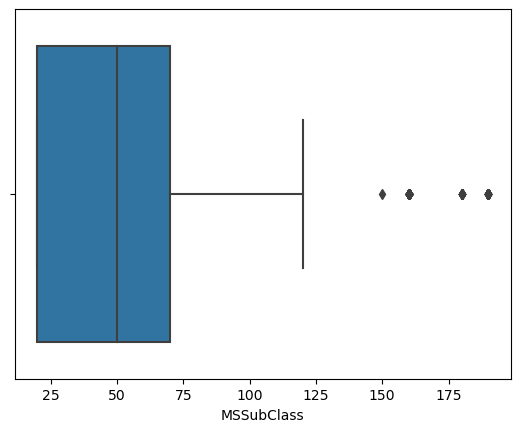

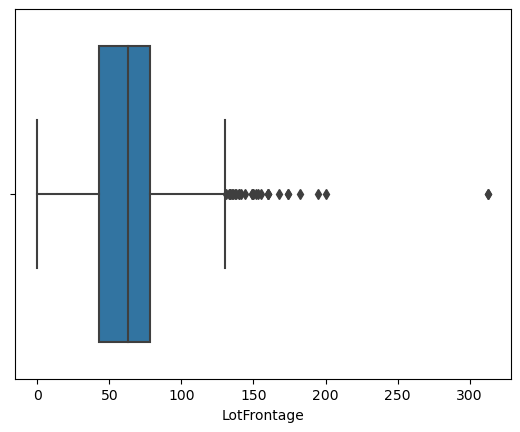

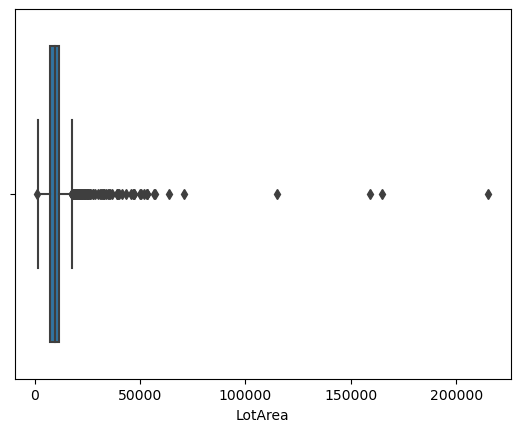

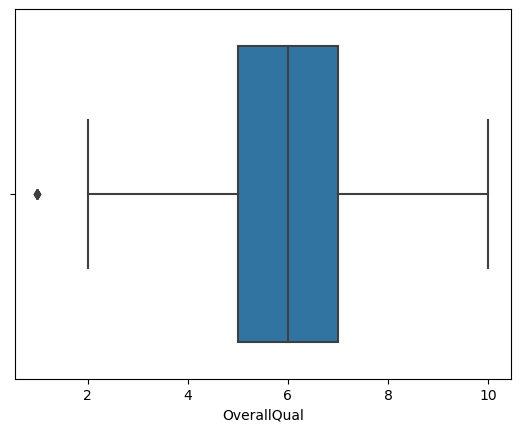

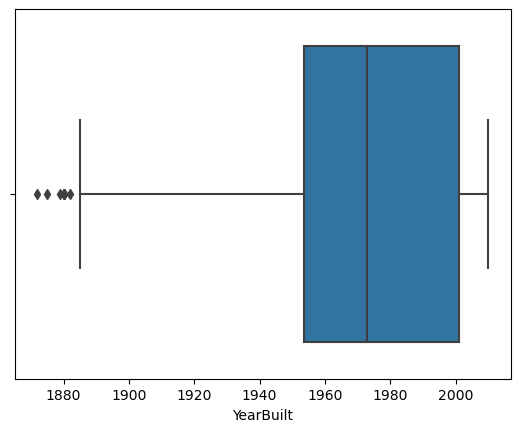

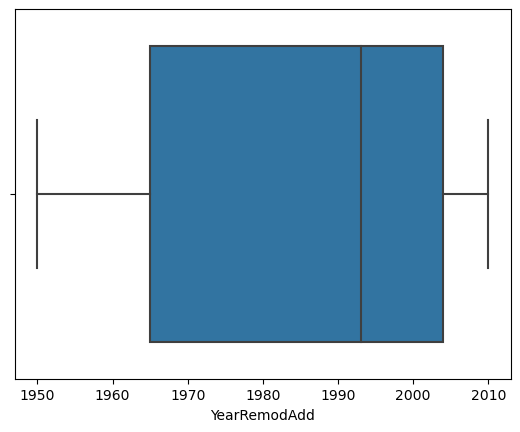

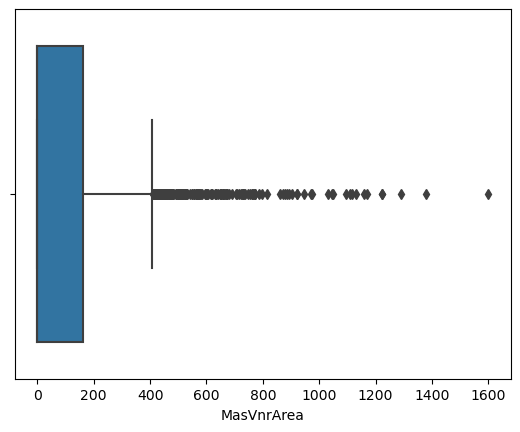

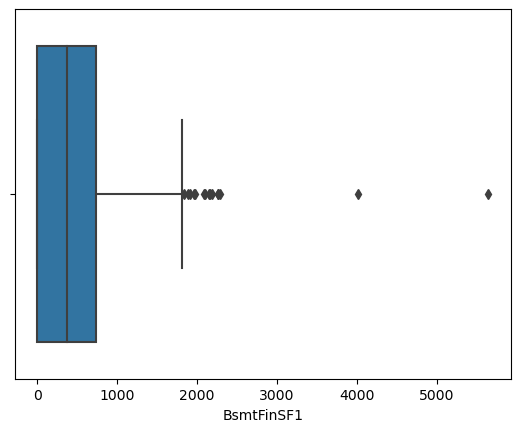

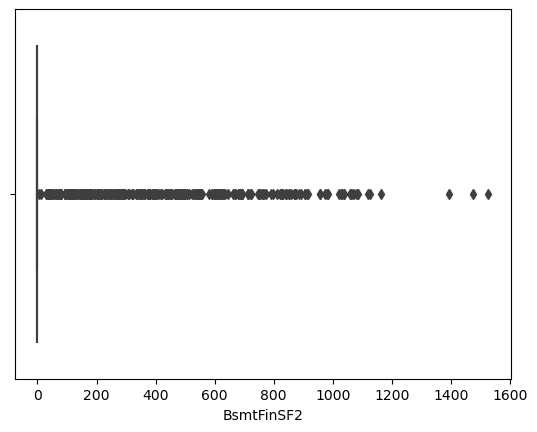

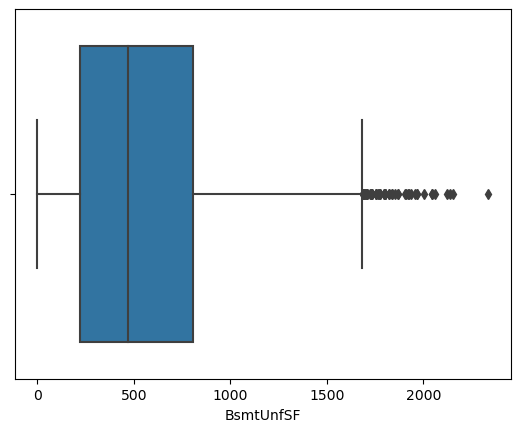

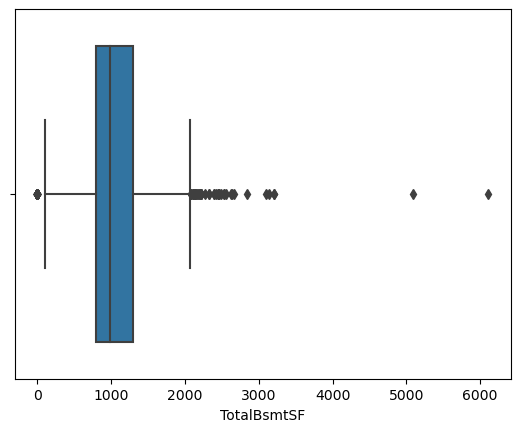

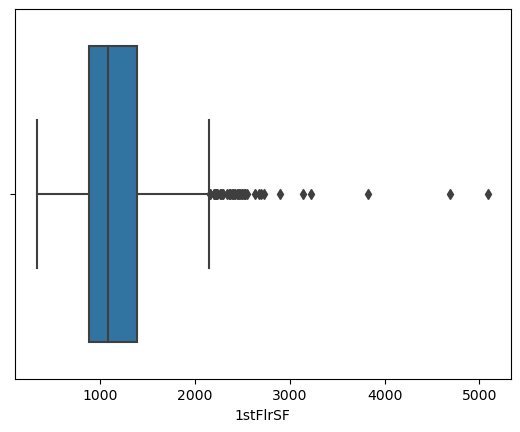

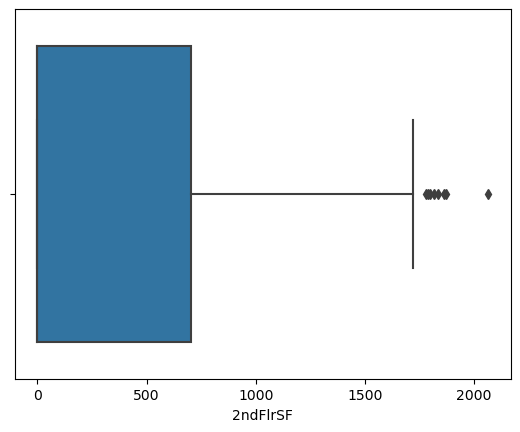

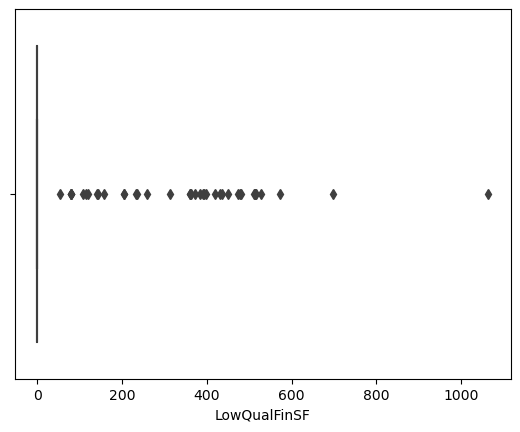

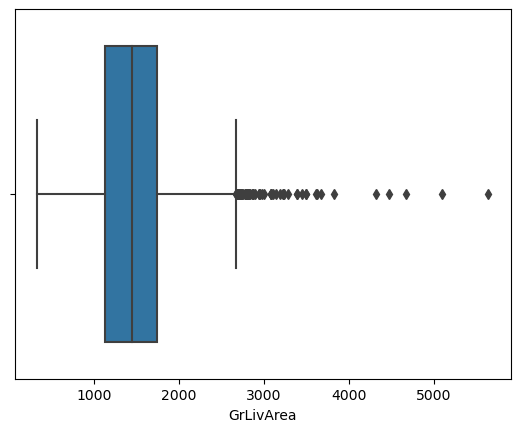

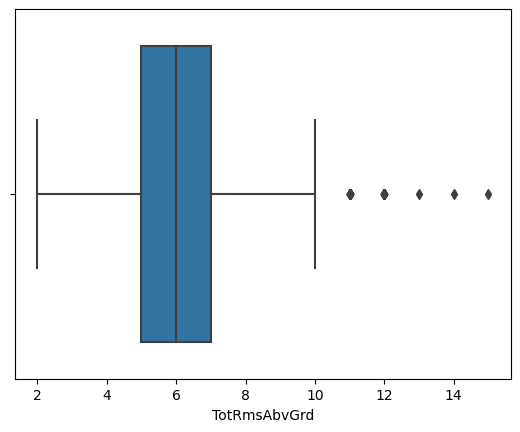

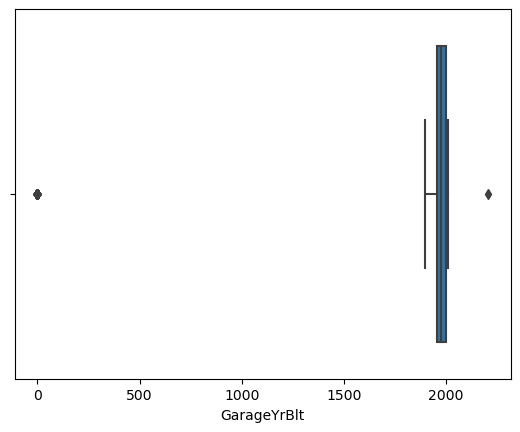

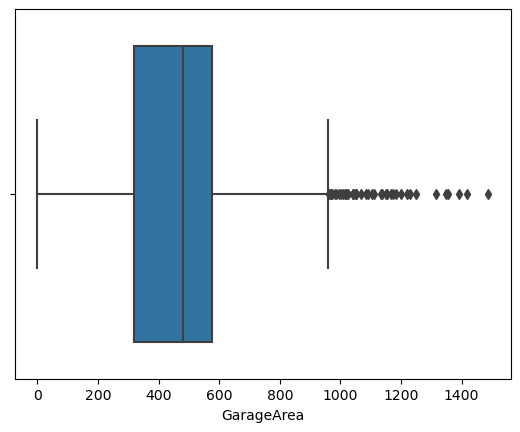

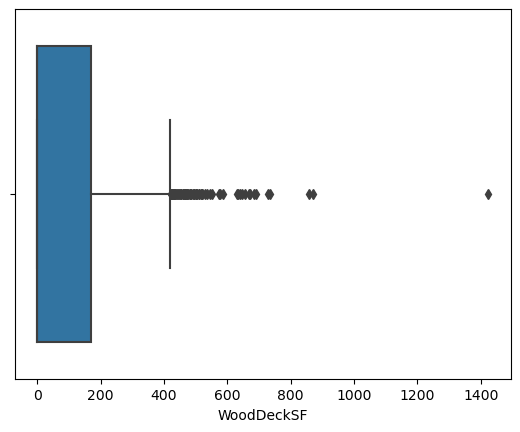

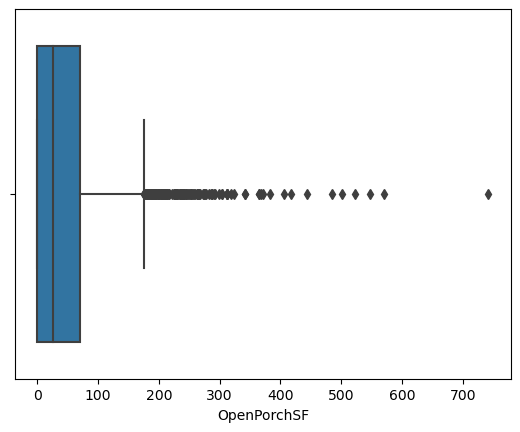

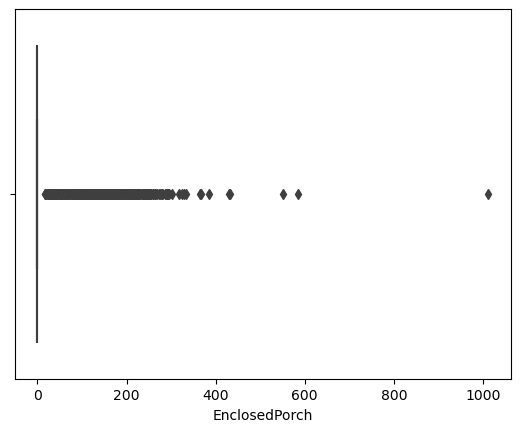

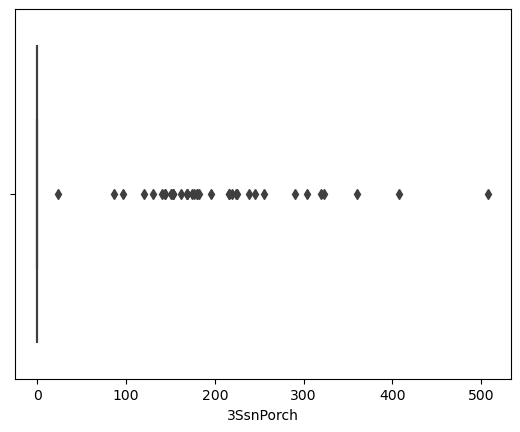

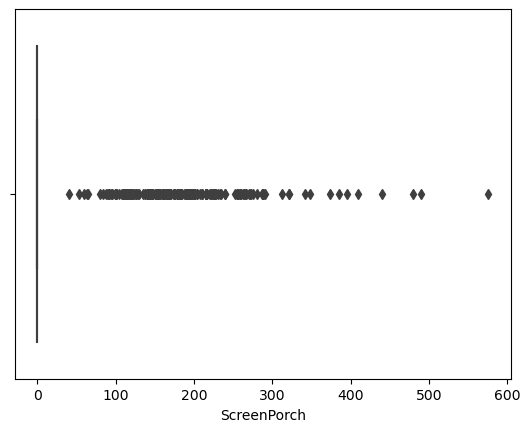

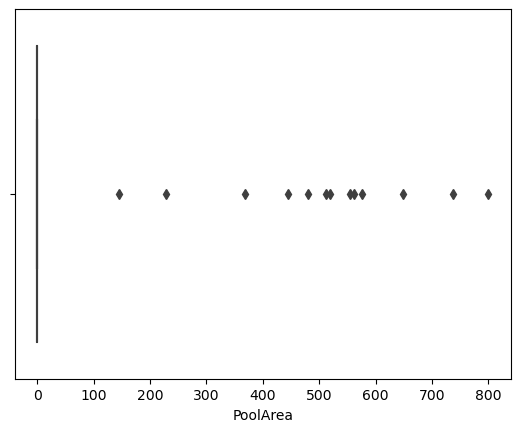

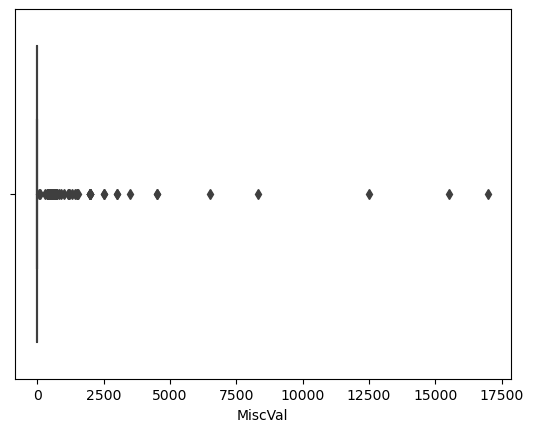

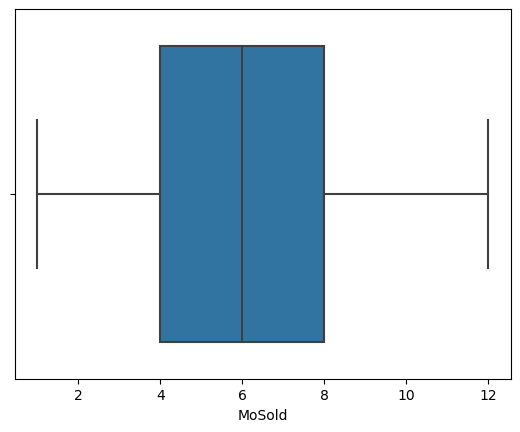

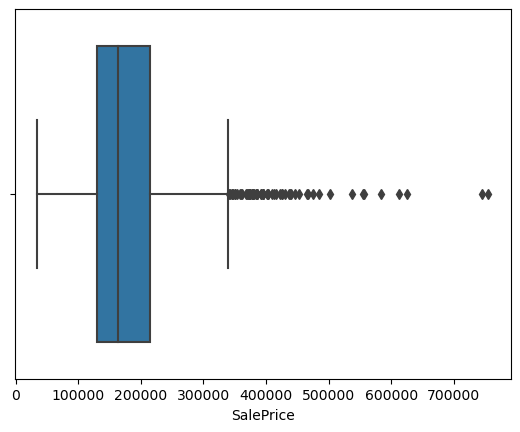

In [31]:
# If we examine the outliers graphically;
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show(block=True)

In [32]:
# Conduct an outlier observation analysis.
## First, the threshold value (threshold), upper and lower limits are determined.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [33]:
## Then we questioned whether there were any outliers

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [34]:
for col in num_cols:
    print(col, check_outlier(df, col))

Id False
MSSubClass True
LotFrontage True
LotArea True
OverallQual True
YearBuilt True
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF True
TotalBsmtSF True
1stFlrSF True
2ndFlrSF True
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea True
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False
SalePrice True


In [35]:
# Suppression of found outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

num_cols = [col for col in num_cols if col not in ["SalePrice"]]

for col in num_cols:
    replace_with_thresholds(df,col)

In [36]:
# If we want to check if there are still outliers after suppressing;

for col in num_cols:
    print(col, check_outlier(df, col))

Id False
MSSubClass False
LotFrontage False
LotArea False
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
MoSold False


### 4.2 Feature Engineering

##### 4.2.1 Create new variables

In [37]:
# YearBuilt: Original build date (old-medium-new)
df["NEW_YEAR_BUILT"] = pd.qcut(df["YearBuilt"], 3, labels=["Old", "Average", "New"])

In [38]:
# total of ground + basement floor m2
df["NEW_TotalFeet"] = df["GrLivArea"] + df["TotalBsmtSF"]

In [39]:
# Total square footage of finished area for Type1 and Type 2
df["NEW_TotalBsmtFin"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]

In [40]:
# ratio of open porch, covered porch, screened porch and wood deck areas to the total area of the house's interior floor areas
df["New_Relation"] = ((df["OpenPorchSF"]+df["EnclosedPorch"] + df["ScreenPorch"] + df["WoodDeckSF"]) /
                      (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']))

In [41]:
# Full bathrooms in the basement + Full bathrooms on the upper floors
df["NEW_FullBath_Total"] = df["BsmtFullBath"] + df["FullBath"]

In [42]:
# Total m2 area of basement, 1st floor and 2nd floor
df['New_TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [43]:
# In these variables, there is only one class that is 96% and above. That's why they don't carry information for us.
drop_list = ["Street","Electrical","GarageYrBlt","LandSlope", "RoofMatl","Utilities", 
             "Condition2", "PoolQC", "MiscFeature", "KitchenAbvGr"]
for col in drop_list:
    df.drop(col, axis=1, inplace=True)

In [44]:
# Since we added new variables, grab_col_names is called again
cat_cols,num_cols,cat_but_car = grab_col_names(df, car_th=26)

Observations: 2919
Variables: 77
cat_cols: 55
num_cols: 22
cat_but_car: 0
num_but_cat: 20


##### 4.2.2 Encoding Operations

In [45]:
# Label Encoder

def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_col = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]


for col in binary_col:
    label_encoder(df, col)

In [46]:
# One-hot Encoder

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe


ohe_cols = [col for col in cat_cols if col not in binary_col]

df = one_hot_encoder(df, ohe_cols)

##### 4.2.3 Standardize for numeric variables

In [47]:
num_cols = [col for col in num_cols if "SalePrice" not in col]

ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])

### 4.3 Modelling

In [48]:
# Separate Training and Test data. (Values with an empty Sale Price variable are test data.)
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [49]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["SalePrice", "Id"], axis=1)

In [50]:
# Build a model with train data and evaluate the success of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [69]:
# For all methods, the measure of train's success is with cv

models = [#('LR', LinearRegression()),
          #('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor(verbose=-1))]


for name, regression in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regression, X_train, y_train, cv=5, scoring="neg_mean_squared_error", verbose=False)))
    print(f"RMSE: {round(rmse, 3)} ({name}) ")

RMSE: 951132051.94 (LR) 
RMSE: 0.167 (KNN) 
RMSE: 0.223 (CART) 
RMSE: 0.15 (RF) 
RMSE: 0.134 (GBM) 
RMSE: 0.152 (XGBoost) 
RMSE: 0.14 (LightGBM) 


In [67]:
def plot_importance(model, features, num=15, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(7,7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

RMSE: 0.2252 (CART)


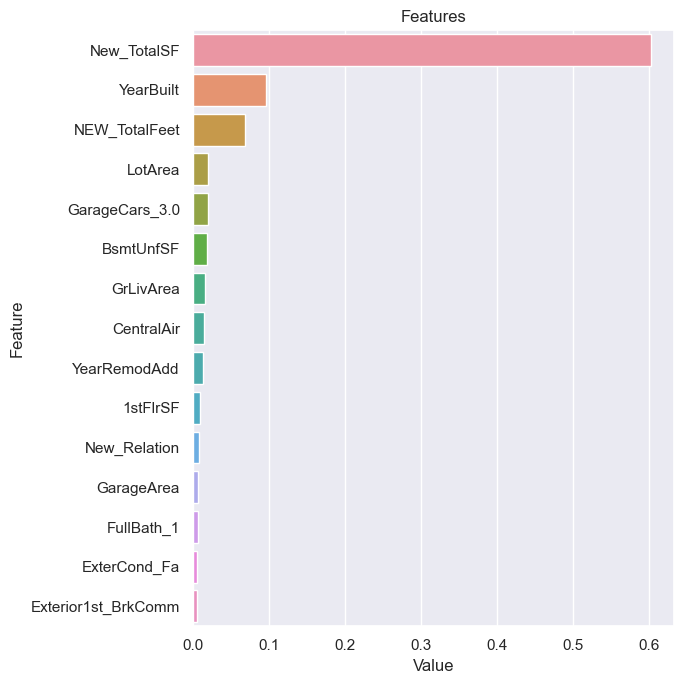

RMSE: 0.143 (RF)


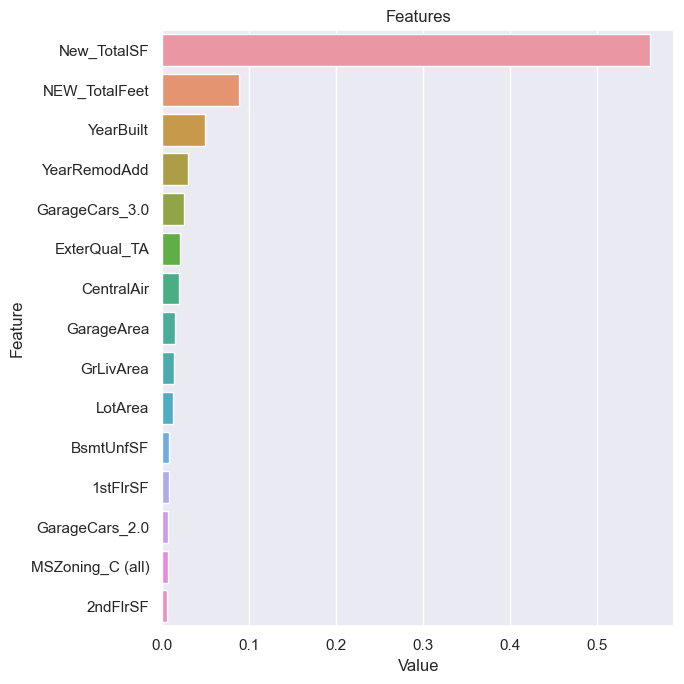

RMSE: 0.1338 (GBM)


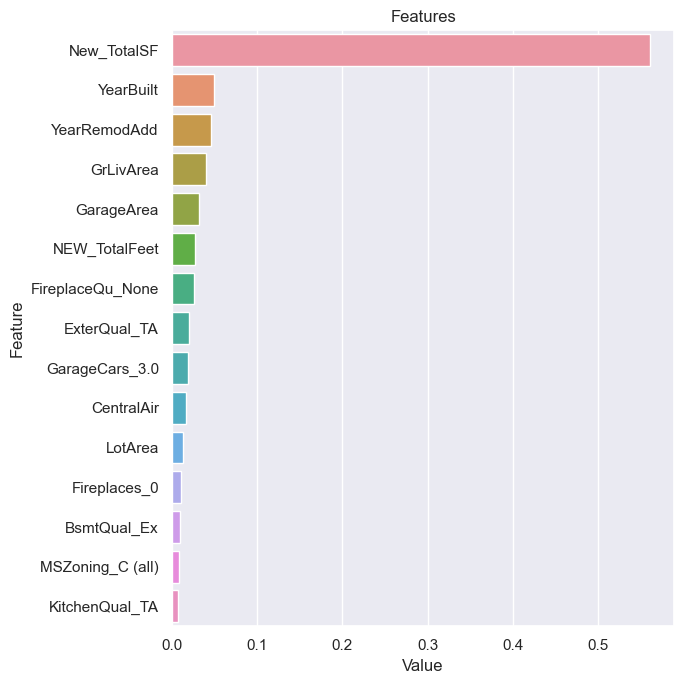

RMSE: 0.1478 (XGBoost)


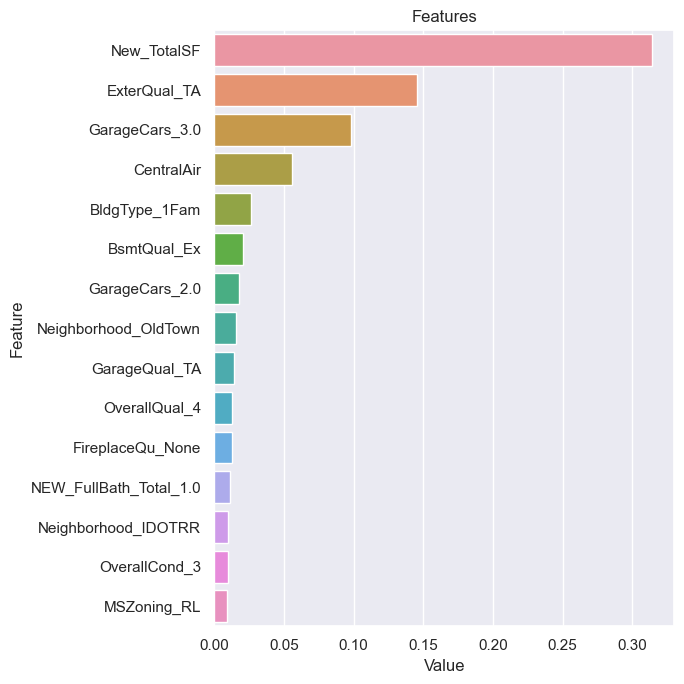

RMSE: 0.1413 (LightGBM)


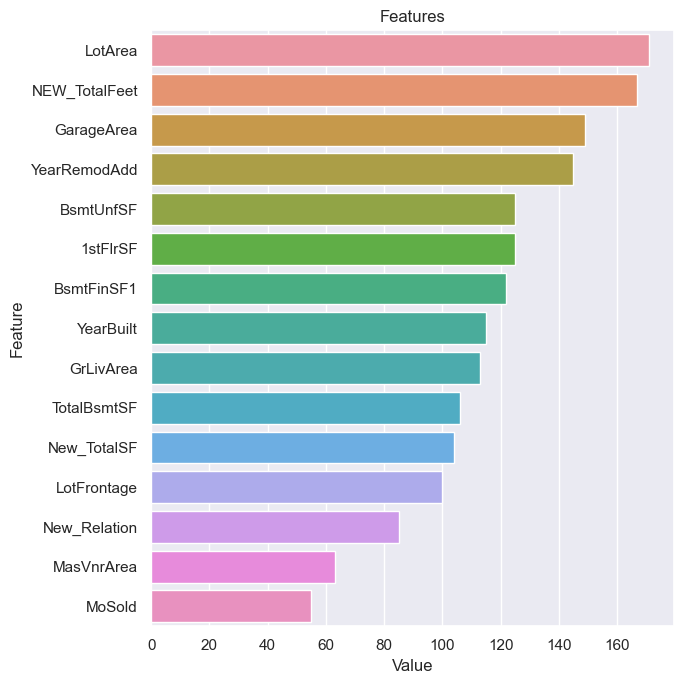

In [68]:
for name, regressor in models:
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {round(rmse, 4)} ({name})")
    
    # Show feature importance ratings
    plot_importance(model, X_train, save=False)

##### 4.3.1 Hyperparameter Optimization

In [54]:
# LightGBM;

lgbm_model = LGBMRegressor(verbose=-1).fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

# CrossVal. rms value with score
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.15954776093471837

In [55]:
lgbm_model.get_params()

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}


lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=False).fit(X_train,y_train)

final_model = lgbm_model.set_params(**lgbm_best_grid.best_params_).fit(X_train,y_train)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.15467119144900948

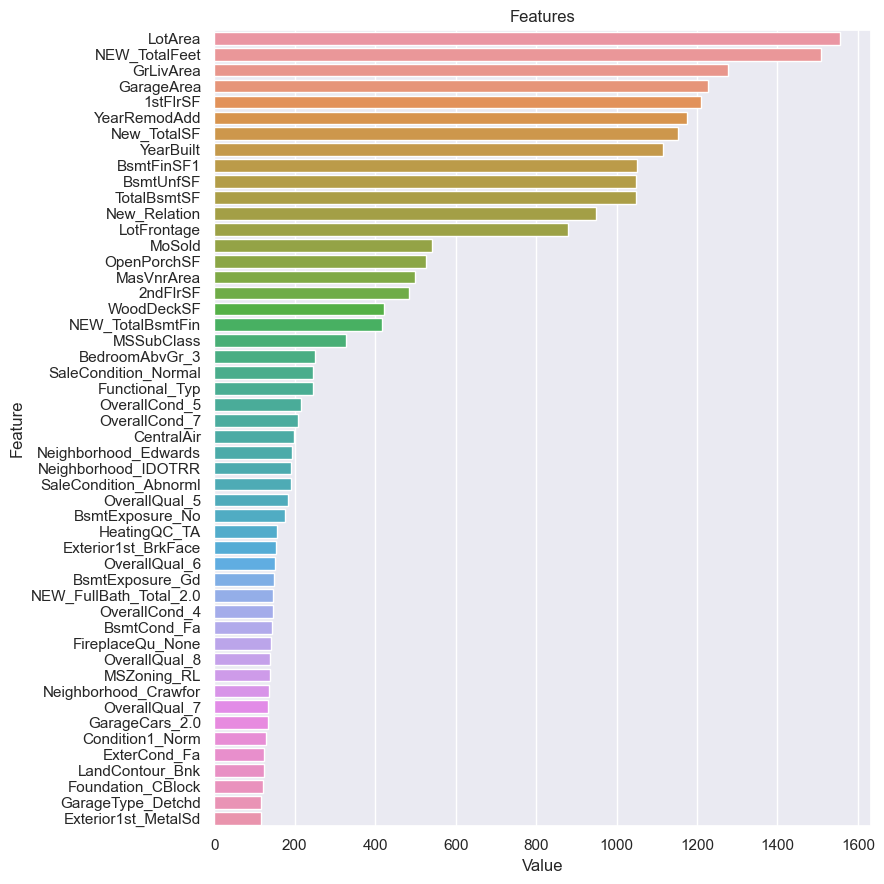

In [56]:
# Featue Importance
##########################
def plot_importance(model, features, num=50, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig("importances.png")



plot_importance(final_model, X_test)

In [57]:
# XgBoost;

xgboost_model = XGBRegressor(eval_metric='logloss',random_state=42).fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)

# CrossVal. rms value with score
rmse = np.mean(np.sqrt(-cross_val_score(xgboost_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.17245801715439998

In [58]:
xgboost_model.get_params()

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100,200,500],
                  "colsample_bytree": [0.5, 1],}


xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=False).fit(X_train,y_train)

final_model = xgboost_model.set_params(**xgboost_best_grid.best_params_).fit(X_train,y_train)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.16342690972065096

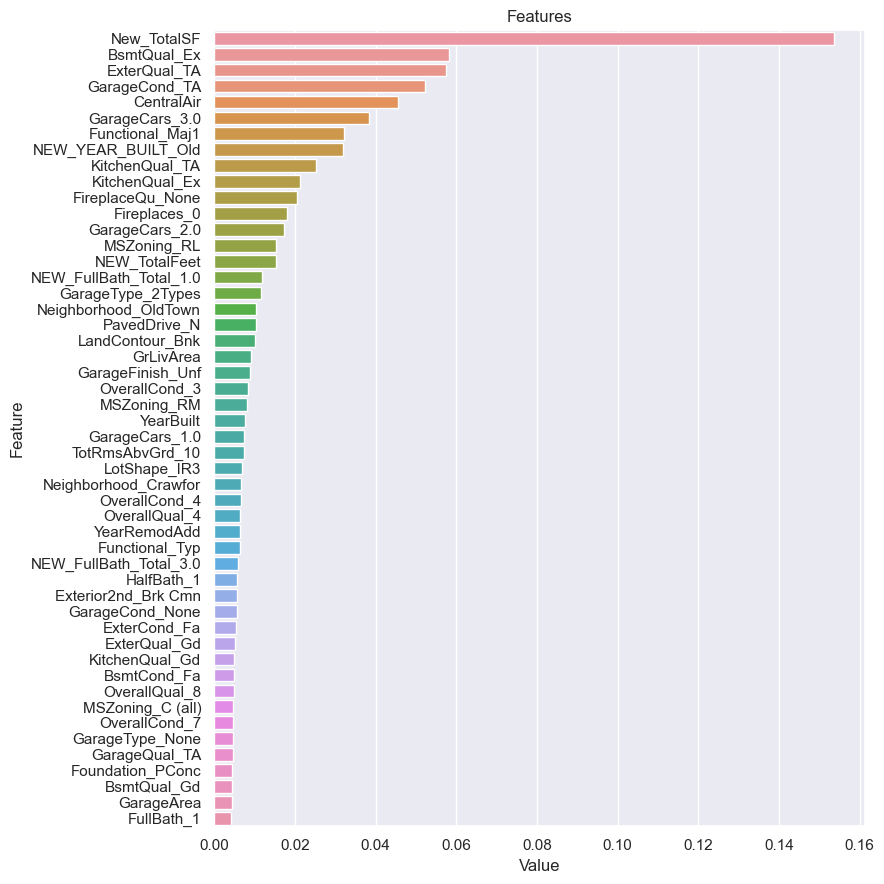

In [59]:
# Featue Importance
##########################
def plot_importance(model, features, num=50, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig("importances.png")



plot_importance(final_model, X_test)

In [60]:
# Cart;

cart_model = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

# CrossVal. rms value with score
rmse = np.mean(np.sqrt(-cross_val_score(cart_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.23386534932324077

In [61]:
cart_model.get_params()


cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30) }


cart_best_grid = GridSearchCV(cart_model, cart_params, cv=5, n_jobs=-1, verbose=False).fit(X_train,y_train)

final_model = cart_model.set_params(**cart_best_grid.best_params_).fit(X_train,y_train)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.2162038546793185

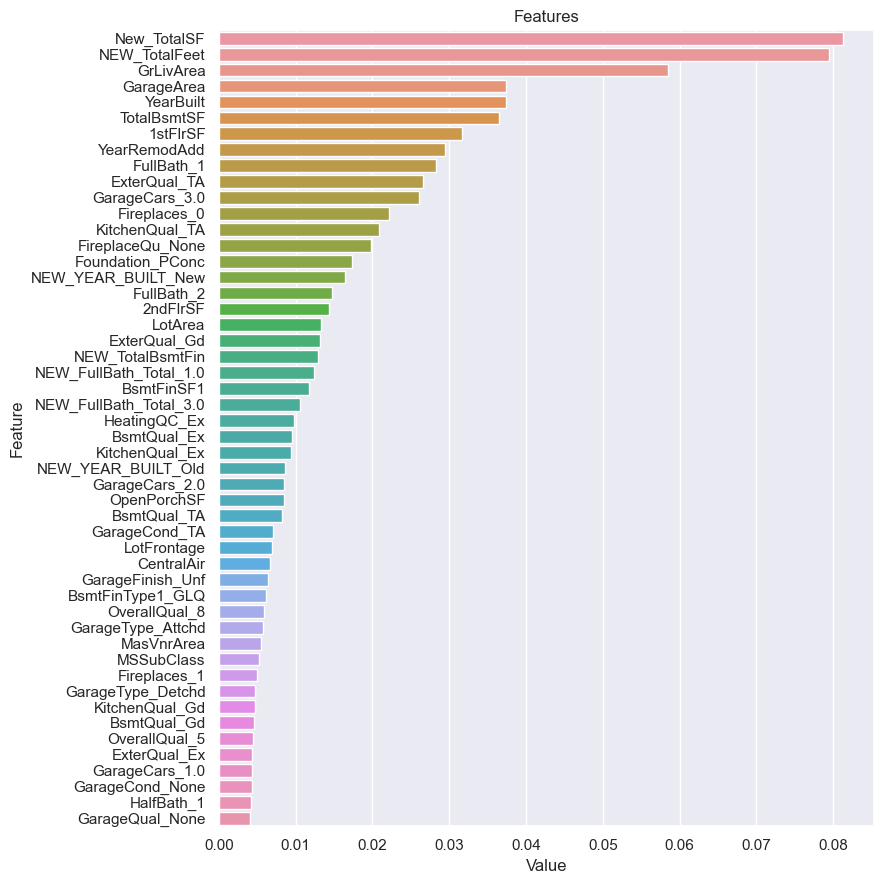

In [69]:
# Featue Importance
##########################
def plot_importance(model, features, num=50, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig("importances.png")



plot_importance(final_model, X_test)

In [57]:
# RandomForest;

rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# CrossVal. rms value with score
rmse = np.mean(np.sqrt(-cross_val_score(rf_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.16490914201993873

In [58]:
rf_model.get_params()

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "sqrt"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300,500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=False).fit(X_train,y_train)

final_model = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train,y_train)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

0.1743254591989281

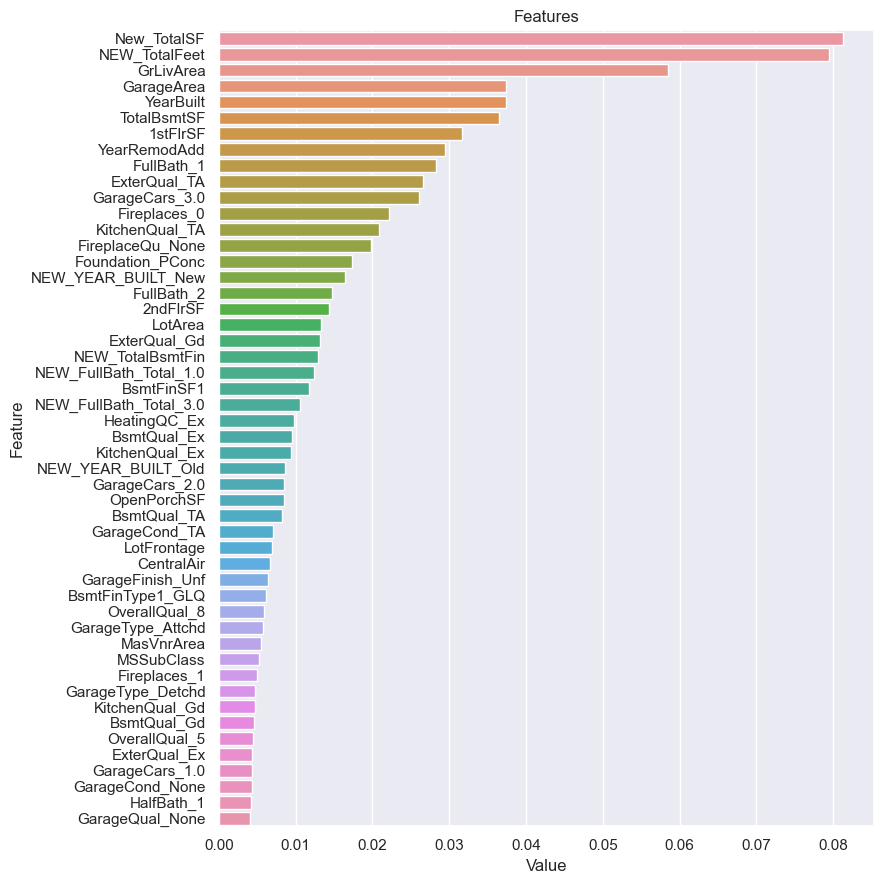

In [60]:
# Featue Importance
##########################
def plot_importance(model, features, num=50, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig("importances.png")



plot_importance(final_model, X_test)